# Results on High-MOI dataset (GI inference)

0. [Readin data, basal state, outcome factor and loadings](#1)     
1. [Factor annotation](#2)
    1. [Selecting top genes in each factor](#3)
    1. [Gene set enrichment analysis](#4)
2. [Growing interaction causal forests](#5)     
    1. [Growing GRF for one target pair to one factor](#6) 
    1. [Growing GRF for all target pairs to all factors](#7)
3. [GI examples](#8) 
    1. [Dominant: DUSP9/ETS2 → Factor 3](#9)
    1. [Buffering: MAPK1/PRTG → Factor 12](#10)
    1. [Synergistic: CBL/UBASH3B → Factor 7](#11)
    1. [Epistasis: MAP2K3/IKZF3 → Factor 7](#12)
4. [Heterogeneous interactions](#13)     
    1. [CBL/CNN1 → Factor 7](#14)     
    1. [Other erythroid differentiation drivers → Factor 7](#15) 
5. [GIs in driving erythroid differentiation](#16)     
    1. [Undirected graph visualization](#17) 
6. [Combining p-values: GI at the whole transcriptome level](#18)     
    1. [Directed graph visualization](#19) 
    1. [Example: SGK1/TBX2/TBX3](#20) 
7. [Overall targets distance](#21)       

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy as sp
import pickle
import gseapy as gp
from fractions import Fraction
from sklearn.linear_model import LinearRegression
from joypy import joyplot

In [2]:
from scCAPE import sccape
from scCAPE import plotting

<a id="1"></a> 
# 0 Readin original data, basal state, factor expression and loadings

Load the processed dataset stored in folder "./data". 

In [3]:
data_path="data/Norman2019_processed.h5ad"
dataset_name="Norman2019_highMOI"

In [4]:
adata=sc.read_h5ad(data_path)
adata

C:\Users\17794\AppData\Roaming\Python\Python39\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 64957 × 5045
    obs: 'condition', 'control', 'condition_name', 'cell_type'
    var: 'gene_name'
    uns: 'condition_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups_cov_all', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

The input adata of scCAPE contains the following metadata:
1. **'condition'**: The perturbation labels. **Note the label of control cells must be 'control'**. **When analyzing high-MOI datasets, the perturbation label must be 'gene_a+gene_b' for two-gene perturbations**;
2. **'cell_type'** (Not necessary): The cell states used in downstream analysis, which can be pre-defined or clustered using some unsupervised algorithms like 'leiden'. If not specified, scCAPE will perform leiden clustering using 'sc.tl.leiden(data, resolution=0.6)' when performing adversarial training;
3. **'condition_name'** (Not necessary) : The labels for performing DEG analysis, which will be used in evaluating reconsturction performance. If not specified, scCAPE will just copy the values in 'condition' when performing adversarial training;
4. **'control'** (Not necessary) : The dummy variable to show if the cell is control (1) or perturbed (0), which will be generated based on perturbation label when performing adversarial training in scCAPE. 

In [5]:
adata.obs.iloc[9:15,:]

condition  control  condition_name cell_type
cell_barcode                                                         
AAACCTGTCAGCGATT-1  UBASH3B+PTPN12        0  UBASH3B+PTPN12         5
AAACCTGTCAGGCGAA-1           FOXA1        0           FOXA1         0
AAACCTGTCCCAGGTG-1     ETS2+IGDCC3        0     ETS2+IGDCC3         1
AAACCTGTCCGATATG-1         control        1         control         2
AAACGGGAGAAACGCC-1            KLF1        0            KLF1         6
AAACGGGAGCGATTCT-1    MAP2K6+IKZF3        0    MAP2K6+IKZF3         2

### Cell-cycle phase annotation

In [6]:
cell_cycle_genes = [x.strip() for x in open(os.path.join(dataset_name,'regev_lab_cell_cycle_genes.txt'))]
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [7]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


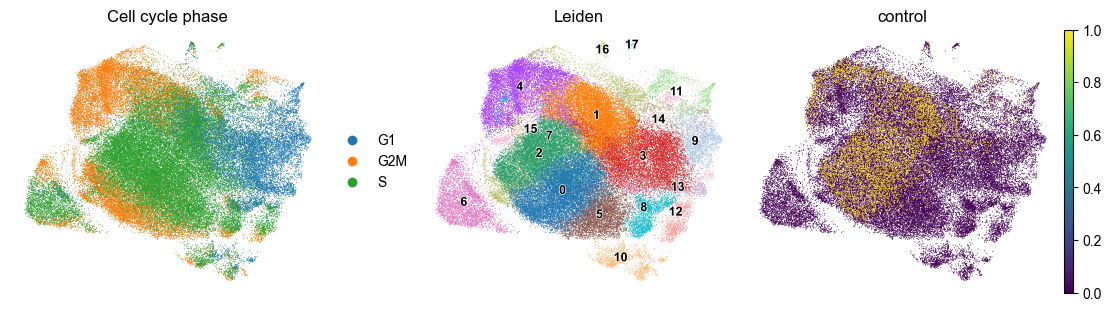

In [8]:
with plt.rc_context({'figure.figsize': (11, 3),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1,3,constrained_layout=True)
    sc.pl.umap(adata,color='phase',title='Cell cycle phase',frameon=False,ax=axs[0],show=False)
    sc.pl.umap(adata,color='cell_type',title='Leiden',legend_loc='on data',frameon=False,legend_fontsize=9, 
               legend_fontoutline=1,ax=axs[1],show=False)
    sc.pl.umap(adata,color='control',title='control',frameon=False,ax=axs[2],show=False)
    plt.show()

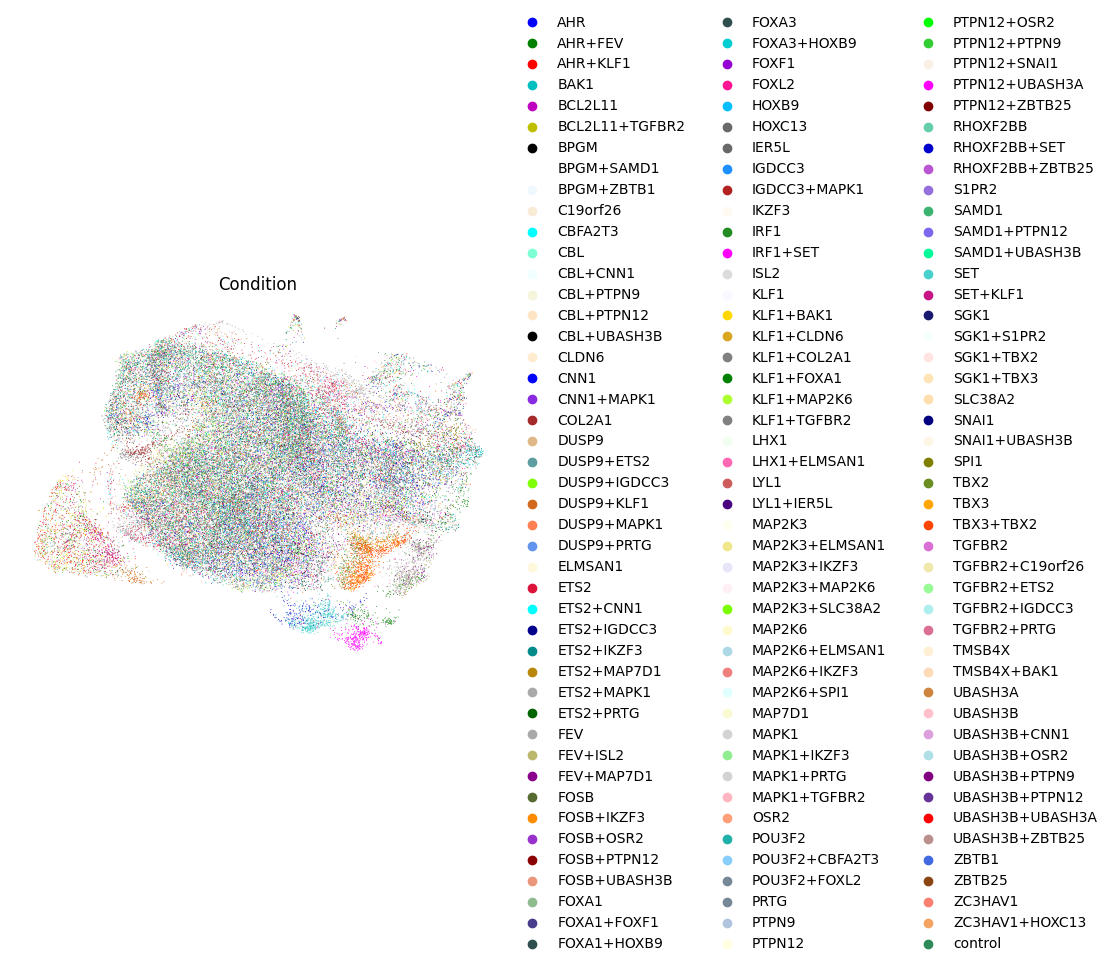

In [9]:
sc.pl.umap(adata,color='condition',title='Condition',frameon=False)

Readin basal state:

In [10]:
model_index=0
basal=sc.read_h5ad(os.path.join(dataset_name,'CAPE','model_index={}_basal.h5ad'.format(model_index)))
sc.pp.neighbors(basal, n_neighbors=10)
sc.tl.umap(basal)

In [11]:
basal.write(os.path.join(dataset_name,'CAPE','model_index={}_basal_umap.h5ad'.format(model_index)))

In [12]:
model_index=0
basal=sc.read_h5ad(os.path.join(dataset_name,'CAPE','model_index={}_basal_umap.h5ad'.format(model_index)))

In [13]:
basal.obs['phase']=adata.obs['phase']
basal.obs['control']=adata.obs['control']
basal.uns['condition_colors']=adata.uns['condition_colors']
basal.uns['cell_type_colors']=adata.uns['cell_type_colors']

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


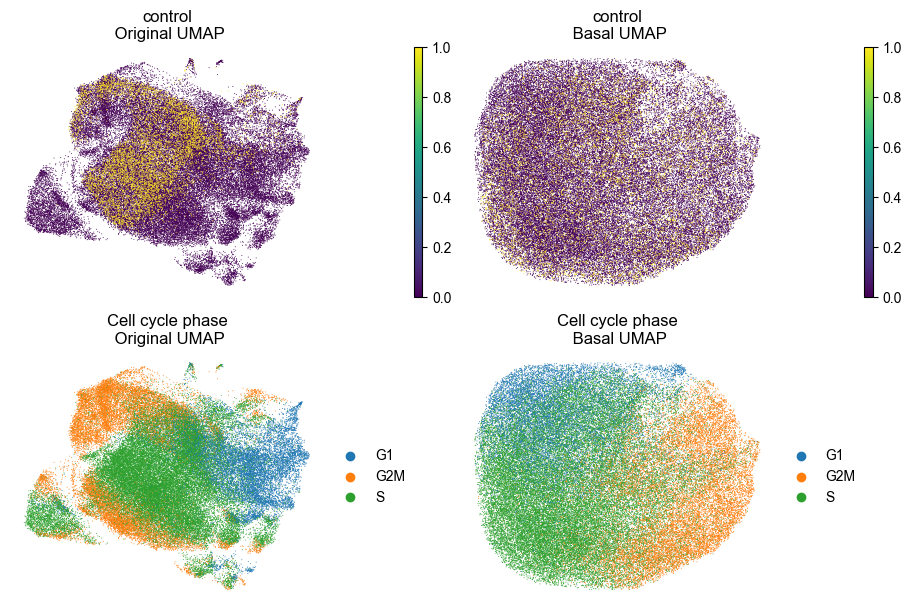

In [14]:
with plt.rc_context({'figure.figsize': (9, 6),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,2,constrained_layout=True)
    sc.pl.umap(adata,color='control',title='control\n Original UMAP',frameon=False,ax=axs[0][0],show=False)
    sc.pl.umap(basal,color='control',title='control\n Basal UMAP',frameon=False,ax=axs[0][1],show=False)
    sc.pl.umap(adata,color='phase',title='Cell cycle phase\n Original UMAP',frameon=False,ax=axs[1][0],show=False)
    sc.pl.umap(basal,color='phase',title='Cell cycle phase\n Basal UMAP',frameon=False,ax=axs[1][1],show=False)
    #plt.savefig(os.path.join('all_figs','supp_figs','Norman_UMAP.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

The perturbation effects are removed ('control' labels are mixed well compared with adata) in basal state. At the same time, the original cell states variations (like cell cycle phases) are preserved.

Readin outcome factor (treated) and loading matrix:

In [15]:
treated=sc.read_h5ad(os.path.join(dataset_name,'CAPE','model_index={}_treated.h5ad'.format(model_index)))
gene_loading=np.load(os.path.join(dataset_name,'CAPE','model_index={}_gene_loading.npy'.format(model_index)))
gene_loading_df=pd.DataFrame(gene_loading,columns=adata.var_names)

<a id="2"></a> 
# 1 Factor annotation

<a id="3"></a> 
## 1.1 select top genes in each factor

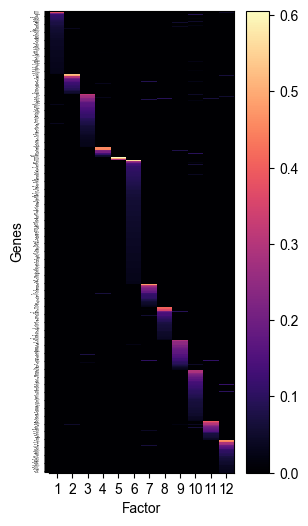

In [16]:
genes_do_go=plotting.plot_top_genes_loadings(gene_names=adata.var_names,W=gene_loading.T,
                                             figsize=(8,6), save_path=None, save=False)

For example, Factor 7 has large loadings for erythroid markers like hemoglobin genes, SLC25A37 (an iron importer involved in heme biosynthesis), GYPA and GYPB (the blood group antigen CD235a and CD235b):

In [17]:
adata.var_names[genes_do_go['6']] # In python the index begins from 0

Index(['HBZ', 'HBG2', 'GYPB', 'GYPA', 'HBG1', 'NENF', 'MYL4', 'SLC25A37',
       'TESC', 'BLVRB', 'COL18A1', 'RP11-717F1.1', 'KLF1', 'UCP2', 'HBA1',
       'ALAS2', 'GSTP1', 'GYPE', 'PITX1', 'MYL6', 'CD7', 'TCF4', 'APOE',
       'ACP5', 'BSG', 'HBD', 'GYPC', 'REEP6', 'SMIM1', 'HBA2', 'CSTB',
       'SLC7A8', 'CHI3L2'],
      dtype='object', name='gene_name')

<a id="4"></a> 
## 1.2 Gene set enrichment analysis

### GO

In [19]:
for factor in range(12):
    go_res = gp.enrichr(gene_list=list(adata.var_names[genes_do_go[str(factor)]]),
                    organism='Human',
                    gene_sets='GO_Biological_Process_2023')
    go_res_df=go_res.results[go_res.results['Adjusted P-value']<=0.05]
    go_res_df['Term']=[term.split(' (')[0] for term in go_res_df.Term.values]
    go_res_df['Overlap']=[float(Fraction(i)) for i in go_res_df.Overlap.values]
    go_res_df.to_csv(os.path.join(dataset_name,'CAPE','GO_factor_{}.csv'.format(factor)))
    print('Finish: {}'.format(factor))

Finish: 0


C:\Users\17794\AppData\Local\Temp\ipykernel_24372\1815558350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_res_df['Term']=[term.split(' (')[0] for term in go_res_df.Term.values]
C:\Users\17794\AppData\Local\Temp\ipykernel_24372\1815558350.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_res_df['Overlap']=[float(Fraction(i)) for i in go_res_df.Overlap.values]


Finish: 1
Finish: 2
Finish: 3
Finish: 4
Finish: 5
Finish: 6
Finish: 7
Finish: 8
Finish: 9
Finish: 10
Finish: 11


### KEGG

In [20]:
for factor in range(12):
    go_res = gp.enrichr(gene_list=list(adata.var_names[genes_do_go[str(factor)]]),
                    organism='Human',
                    gene_sets='KEGG_2021_Human')
    go_res_df=go_res.results[go_res.results['Adjusted P-value']<=0.05]
    go_res_df['Term']=[term.split(' (')[0] for term in go_res_df.Term.values]
    go_res_df['Overlap']=[float(Fraction(i)) for i in go_res_df.Overlap.values]
    go_res_df.to_csv(os.path.join(dataset_name,'CAPE','KEGG_factor_{}.csv'.format(factor)))
    print('Finish: {}'.format(factor))

Finish: 0


C:\Users\17794\AppData\Local\Temp\ipykernel_24372\267082499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_res_df['Term']=[term.split(' (')[0] for term in go_res_df.Term.values]
C:\Users\17794\AppData\Local\Temp\ipykernel_24372\267082499.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_res_df['Overlap']=[float(Fraction(i)) for i in go_res_df.Overlap.values]


Finish: 1
Finish: 2
Finish: 3
Finish: 4
Finish: 5
Finish: 6
Finish: 7
Finish: 8
Finish: 9
Finish: 10
Finish: 11


In [21]:
#We combined the results of GO and KEGG, and write them in the GO files
#read GO res
GO_total_df=pd.DataFrame([])
num_selected=[3]*12
for factor in range(12):
    GO_df=pd.read_csv(os.path.join(dataset_name,'CAPE','GO_factor_{}.csv'.format(factor)))
    selected_pathway_nums=min(len(GO_df),num_selected[factor])
    if selected_pathway_nums==0:
        pass
    else:
        GO_df=(GO_df.loc[:,['Term','Adjusted P-value','Overlap']]).head(selected_pathway_nums)
        GO_df['Factor']=factor
        GO_total_df=GO_total_df.append(GO_df,ignore_index = True)

In [22]:
GO_total_df.head(4)

Term  Adjusted P-value   Overlap  Factor
0           Polyamine Metabolic Process          0.010119  0.181818       1
1      Biogenic Amine Metabolic Process          0.010119  0.166667       1
2  DNA Replication Checkpoint Signaling          0.013848  0.117647       1
3  Leukocyte transendothelial migration          0.000098  0.052632       2

In [23]:
GO_total_df['y_ticks']=(0.2*GO_total_df.index)[::-1]
GO_total_df['Adjusted P-value']=-np.log10(GO_total_df['Adjusted P-value'])
for i in range(len(GO_total_df)):
    for j in range(i):
        if GO_total_df.loc[i,'Term']==GO_total_df.loc[j,'Term']:
            GO_total_df.loc[i,'y_ticks']=GO_total_df.loc[j,'y_ticks']
            GO_total_df.loc[(i+1):(len(GO_total_df)-1),'y_ticks']=GO_total_df.loc[(i+1):(len(GO_total_df)-1),'y_ticks']+0.2

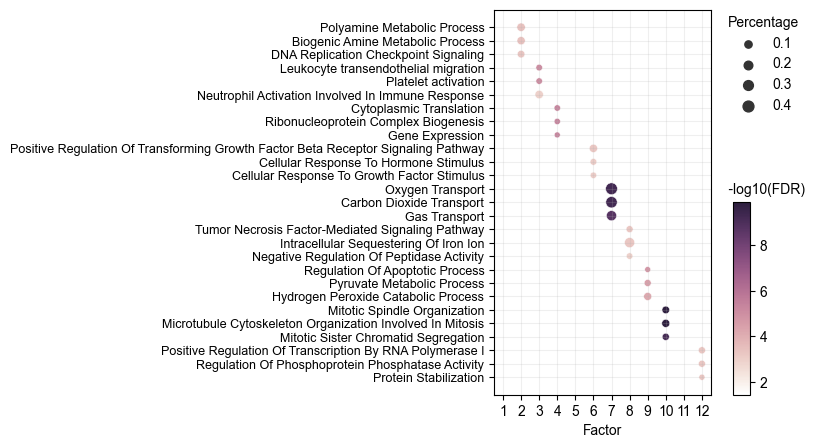

In [24]:
factor_nums=12
with plt.rc_context({'figure.figsize': (2.8, 5),'font.sans-serif':['Arial']}):
    fig, ax = plt.subplots()
    g=sns.scatterplot(data=GO_total_df,x = 'Factor', y ='y_ticks' , hue='Adjusted P-value',size='Overlap', ax=ax)
    h,l = g.get_legend_handles_labels()
    plt.legend(h[8:12],l[8:12],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False,title='Percentage')
    plt.xticks(np.arange(factor_nums),np.arange(factor_nums)+1)
    plt.yticks((GO_total_df.drop_duplicates(subset = "Term"))['y_ticks'],
               (GO_total_df.drop_duplicates(subset = "Term"))['Term'], fontsize=9)
    plt.ylabel('')
    plt.xlim([-0.5,11.5])
    plt.grid(alpha=0.2) 
    norm = plt.Normalize(GO_total_df['Adjusted P-value'].min(), GO_total_df['Adjusted P-value'].max())
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.add_axes([ax.get_position().x1+0.08, ax.get_position().y0, 0.06, ax.get_position().height / 2])
    cbar=ax.figure.colorbar(sm, cax=cax)
    cbar.ax.set_title('             -log10(FDR)',fontsize=10)
    #plt.savefig(os.path.join('all_figs','supp_figs','Norman_GO_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

### Enrichment results for factor 3, 6, 7, 12

In [25]:
GO_total_df=pd.DataFrame([])
num_selected=[0]*12
num_selected[2]=3
num_selected[5]=3
num_selected[6]=3
num_selected[11]=3
idx=0
for factor in [2,5,6,11]:
    GO_df=pd.read_csv(os.path.join(dataset_name,'CAPE','GO_factor_{}.csv'.format(factor)))
    selected_pathway_nums=min(len(GO_df),num_selected[factor])
    if selected_pathway_nums==0:
        pass
    else:
        GO_df=(GO_df.loc[:,['Term','Adjusted P-value','Overlap']]).head(selected_pathway_nums)
        GO_df['Factor']=idx
        GO_total_df=GO_total_df.append(GO_df,ignore_index = True)
        idx=idx+1

In [26]:
GO_total_df['y_ticks']=(0.2*GO_total_df.index)[::-1]
GO_total_df['Adjusted P-value']=-np.log10(GO_total_df['Adjusted P-value'])
for i in range(len(GO_total_df)):
    for j in range(i):
        if GO_total_df.loc[i,'Term']==GO_total_df.loc[j,'Term']:
            GO_total_df.loc[i,'y_ticks']=GO_total_df.loc[j,'y_ticks']
            GO_total_df.loc[(i+1):(len(GO_total_df)-1),'y_ticks']=GO_total_df.loc[(i+1):(len(GO_total_df)-1),'y_ticks']+0.2

In [27]:
GO_total_df.loc[3,'Term']='Positive Regulation Of Transforming Growth Factor \n Beta Receptor Signaling Pathway'

In [28]:
GO_total_df.loc[9,'Term']='Positive Regulation Of Transcription \n By RNA Polymerase I'

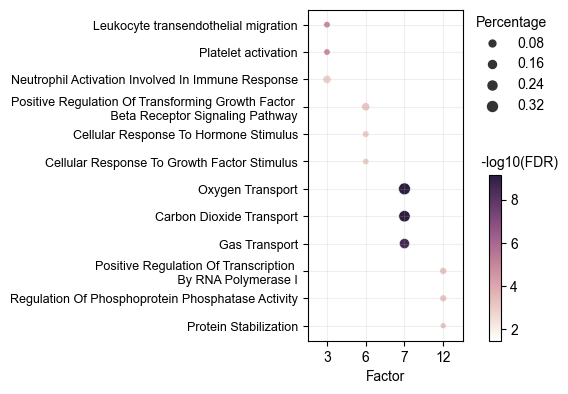

In [29]:
factor_nums=4
with plt.rc_context({'figure.figsize': (2, 4.3),'font.sans-serif':['Arial']}):
    fig, ax = plt.subplots()
    g=sns.scatterplot(data=GO_total_df,x = 'Factor', y ='y_ticks' , hue='Adjusted P-value',size='Overlap', ax=ax)
    h,l = g.get_legend_handles_labels()
    plt.legend(h[8:12],l[8:12],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False,title='Percentage')
    plt.xticks(np.arange(factor_nums),[3,6,7,12])
    plt.yticks((GO_total_df.drop_duplicates(subset = "Term"))['y_ticks'],
               (GO_total_df.drop_duplicates(subset = "Term"))['Term'], fontsize=9)
    plt.ylabel('')
    plt.xlim([-0.5,3.5])
    plt.grid(alpha=0.2) 
    norm = plt.Normalize(GO_total_df['Adjusted P-value'].min(), GO_total_df['Adjusted P-value'].max())
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.add_axes([ax.get_position().x1+0.13, ax.get_position().y0, 0.06, ax.get_position().height / 2])
    cbar=ax.figure.colorbar(sm, cax=cax)
    cbar.ax.set_title('             -log10(FDR)',fontsize=10)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','GO_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

<a id="5"></a> 
# 2 Interaction Causal Forests

<a id="6"></a> 
## 2.1 Genetic interaction inference for one target pair on one factor

In [30]:
res=sccape.CF_GI_single_target_single_factor(dataset_name=dataset_name,target='CBL+CNN1', factor=6,
                                              basal=basal,treated=treated, adata=adata, pert_key='condition', 
                                              n_estimators=1000,min_samples_leaf=5,verbose=True,
                                      random_state=0,one_side=False,alpha=0.05,return_ctrl=True,save=False)

Finish GI calculation in target=CBL+CNN1 factor=6


In [31]:
res.head(4)

tau_a     tau_b   tau_int        pval_a         pval_b  pval_int  \
0  1.385493  2.018339  1.556057  7.636371e-04   1.028534e-08  0.134579   
1  2.306505  2.925938  0.692956  4.732257e-99  6.965548e-300  0.000341   
2  2.015366  2.668934  0.520636  4.251686e-18   1.112650e-32  0.526081   
3  0.998597  1.544624  1.774473  5.970651e-04   2.018241e-11  0.659007   

   sign_sig_a  sign_sig_b  sign_sig_int   pval_SY  ...  pval_DM  \
0         1.0         1.0           0.0  0.067289  ...      1.0   
1         1.0         1.0           1.0  0.000171  ...      1.0   
2         1.0         1.0           0.0  0.263040  ...      1.0   
3         1.0         1.0           0.0  0.329503  ...      1.0   

       pval_epia      pval_epib  sig_SY  sig_BF  sig_DM  sig_epia  sig_epib  \
0   4.796619e-04   1.328664e-04     0.0     0.0     0.0       0.0       0.0   
1  2.245009e-159  2.631056e-125     1.0     0.0     0.0       0.0       0.0   
2   5.330475e-11   4.424873e-13     0.0     0.0     0.0       0.0       0.0   
3   3.045427e-01   3.890659e-01     0.0     0.0     0.0       0.0       0.0   

   sig_RD  sig_NE  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     1.0     0.0  

[4 rows x 21 columns]

In [32]:
res.columns
# tau_a (tau_b): CATE of target a (target b)
# tau_int: Estimation of interaction effects
# pval_a (pval_b): marginal p-value of target a (target b)
# pval_int: marginal p-value of interaction
# sign_sig_a (sign_sig_b): signed sig of target a (target b) [-1 (+1): significantly <0 (>0), 0: not significant]
# sign_sig_int: signed sig of interaction [-1 (+1): significantly <0 (>0), 0: not significant]
# pval_SY, pval_BF, pval_DM, pval_epia, pval_epib: pval of GI tests (Synergistic, buffering, dominant, epistasis a, epistasis b)
# sig_SY, sig_BF, sig_DM, sig_epia, sig_epib: sig of GI tests [significant (1) or not (0)]
# sig_RD: indicator of redundant (tau_ab=tau_a=tau_b)
# sig_NE: indicator of no effects (tau_a=tau_b=tau_int=0)

Index(['tau_a', 'tau_b', 'tau_int', 'pval_a', 'pval_b', 'pval_int',
       'sign_sig_a', 'sign_sig_b', 'sign_sig_int', 'pval_SY', 'pval_BF',
       'pval_DM', 'pval_epia', 'pval_epib', 'sig_SY', 'sig_BF', 'sig_DM',
       'sig_epia', 'sig_epib', 'sig_RD', 'sig_NE'],
      dtype='object')

C:\Users\17794\AppData\Roaming\Python\Python39\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


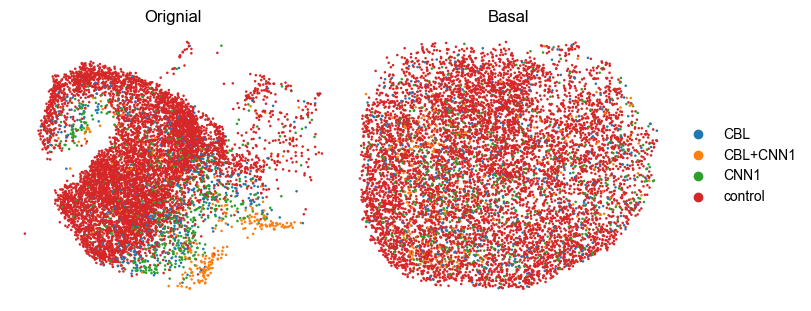

In [33]:
with plt.rc_context({'figure.figsize': (8, 3),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1,2,constrained_layout=True)
    sc.pl.umap(adata[adata.obs.condition.isin(['CBL+CNN1','CBL','CNN1','control'])],color='condition',title='Orignial',frameon=False,legend_loc='none',ax=axs[0],show=False)
    sc.pl.umap(basal[basal.obs.condition.isin(['CBL+CNN1','CBL','CNN1','control'])],color='condition',title='Basal',frameon=False,ax=axs[1],show=False)
    plt.show()

In [34]:
subset=adata[adata.obs['condition'].isin(['CBL', 'CNN1','CBL+CNN1', 'control'])]
subset=subset[subset.obs.control==1]

In [35]:
subset.obs['tau_a']=res['tau_a'].values
subset.obs['tau_b']=res['tau_b'].values
subset.obs['tau_int']=res['tau_int'].values
subset.obs['sign_sig_a']=res['sign_sig_a'].values
subset.obs['sign_sig_b']=res['sign_sig_b'].values
subset.obs['sig_SY']=res['sig_SY'].values

C:\Users\17794\AppData\Local\Temp\ipykernel_16628\2003454562.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs['tau_a']=res['tau_a'].values


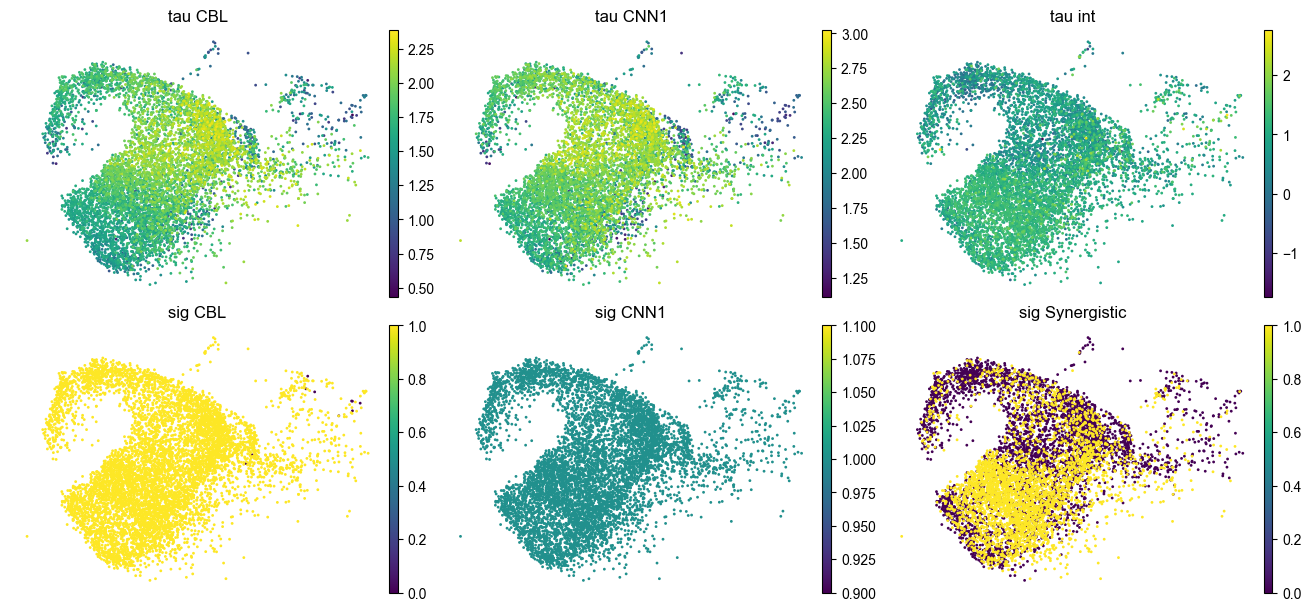

In [36]:
with plt.rc_context({'figure.figsize': (13, 6),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,3,constrained_layout=True)
    sc.pl.umap(subset,color='tau_a',title='tau CBL',frameon=False,ax=axs[0][0],show=False)
    sc.pl.umap(subset,color='tau_b',title='tau CNN1',frameon=False,ax=axs[0][1],show=False)
    sc.pl.umap(subset,color='tau_int',title='tau int',frameon=False,ax=axs[0][2],show=False)
    sc.pl.umap(subset,color='sign_sig_a',title='sig CBL',frameon=False,ax=axs[1][0],show=False)
    sc.pl.umap(subset,color='sign_sig_b',title='sig CNN1',frameon=False,ax=axs[1][1],show=False)
    sc.pl.umap(subset,color='sig_SY',title='sig Synergistic',frameon=False,ax=axs[1][2],show=False)
    plt.show()

<a id="7"></a> 
## 2.2 Genetic interaction inference for all target pairs on all factors

In [37]:
target_list=[]
for i in list(adata.obs.condition.cat.categories):
    if len(i.split('+'))==2:
        target_list.append(i)

In [38]:
factor_nums=12
#percentage of cells that are significant (q-value<0.05) in the GI test
BF_all_res=np.zeros([len(target_list),factor_nums]) 
SY_all_res=np.zeros([len(target_list),factor_nums])
DM_all_res=np.zeros([len(target_list),factor_nums])

epiA_all_res=np.zeros([len(target_list),factor_nums])
epiB_all_res=np.zeros([len(target_list),factor_nums])
RD_all_res=np.zeros([len(target_list),factor_nums])
NE_all_res=np.zeros([len(target_list),factor_nums])

Using for-loops to infer GIs for all target pairs: (CAUTION: This will take about 6 hours on a laptop)

In [40]:
for m in range(len(target_list)):
    for n in range(factor_nums):
        target=target_list[m]
        res=sccape.CF_GI_single_target_single_factor(dataset_name=dataset_name,target=target, factor=n)
        BF_all_res[m,n]=res.mean(axis=0)['sig_BF']
        SY_all_res[m,n]=res.mean(axis=0)['sig_SY']
        DM_all_res[m,n]=res.mean(axis=0)['sig_DM']
        
        epiA_all_res[m,n]=res.mean(axis=0)['sig_epia']
        epiB_all_res[m,n]=res.mean(axis=0)['sig_epib']
        RD_all_res[m,n]=res.mean(axis=0)['sig_RD']
        NE_all_res[m,n]=res.mean(axis=0)['sig_NE']

In [41]:
np.save(os.path.join(dataset_name,'CausalForests','BF_all_res.npy'),BF_all_res)
np.save(os.path.join(dataset_name,'CausalForests','SY_all_res.npy'),SY_all_res)
np.save(os.path.join(dataset_name,'CausalForests','DM_all_res.npy'),DM_all_res)

np.save(os.path.join(dataset_name,'CausalForests','epiA_all_res.npy'),epiA_all_res)
np.save(os.path.join(dataset_name,'CausalForests','epiB_all_res.npy'),epiB_all_res)
np.save(os.path.join(dataset_name,'CausalForests','RD_all_res.npy'),RD_all_res)
np.save(os.path.join(dataset_name,'CausalForests','NE_all_res.npy'),NE_all_res)

In [42]:
BF_all_res=np.load(os.path.join(dataset_name,'CausalForests','BF_all_res.npy'))
SY_all_res=np.load(os.path.join(dataset_name,'CausalForests','SY_all_res.npy'))
DM_all_res=np.load(os.path.join(dataset_name,'CausalForests','DM_all_res.npy'))
epiA_all_res=np.load(os.path.join(dataset_name,'CausalForests','epiA_all_res.npy'))
epiB_all_res=np.load(os.path.join(dataset_name,'CausalForests','epiB_all_res.npy'))

In [43]:
BF_all_res.shape # 79 gene pairs * 12 factors

(79, 12)

Plotting the results of factor 3,6,7,12:

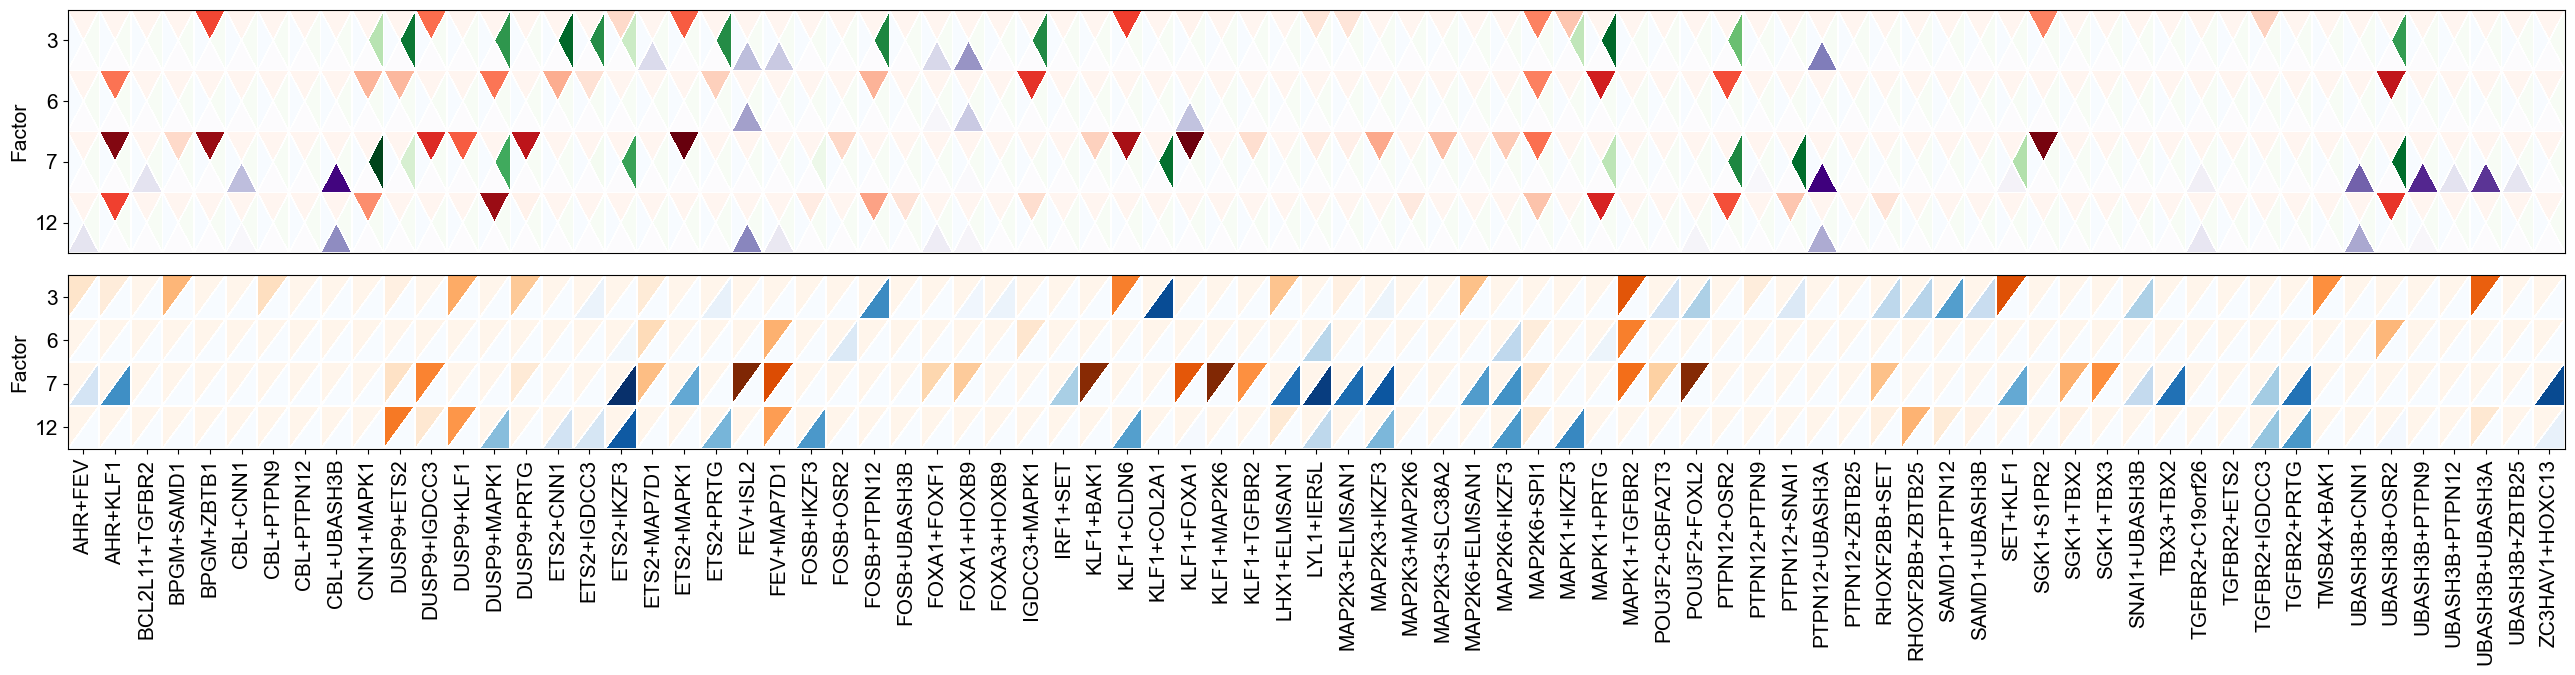

In [44]:
plotting.GI_triangle_plot(BF_all_res=BF_all_res,DM_all_res=DM_all_res,SY_all_res=SY_all_res,epiA_all_res=epiA_all_res,epiB_all_res=epiB_all_res,
                     target_list=target_list,show_factors=[2,5,6,11],show_targets='All',vmin_1=0.2,vmin_2=0.3,
                     figsize=(26,7),save_path='all_figs/Norman2019_highMOI_figs',save=False)

Plotting the results of all factors:

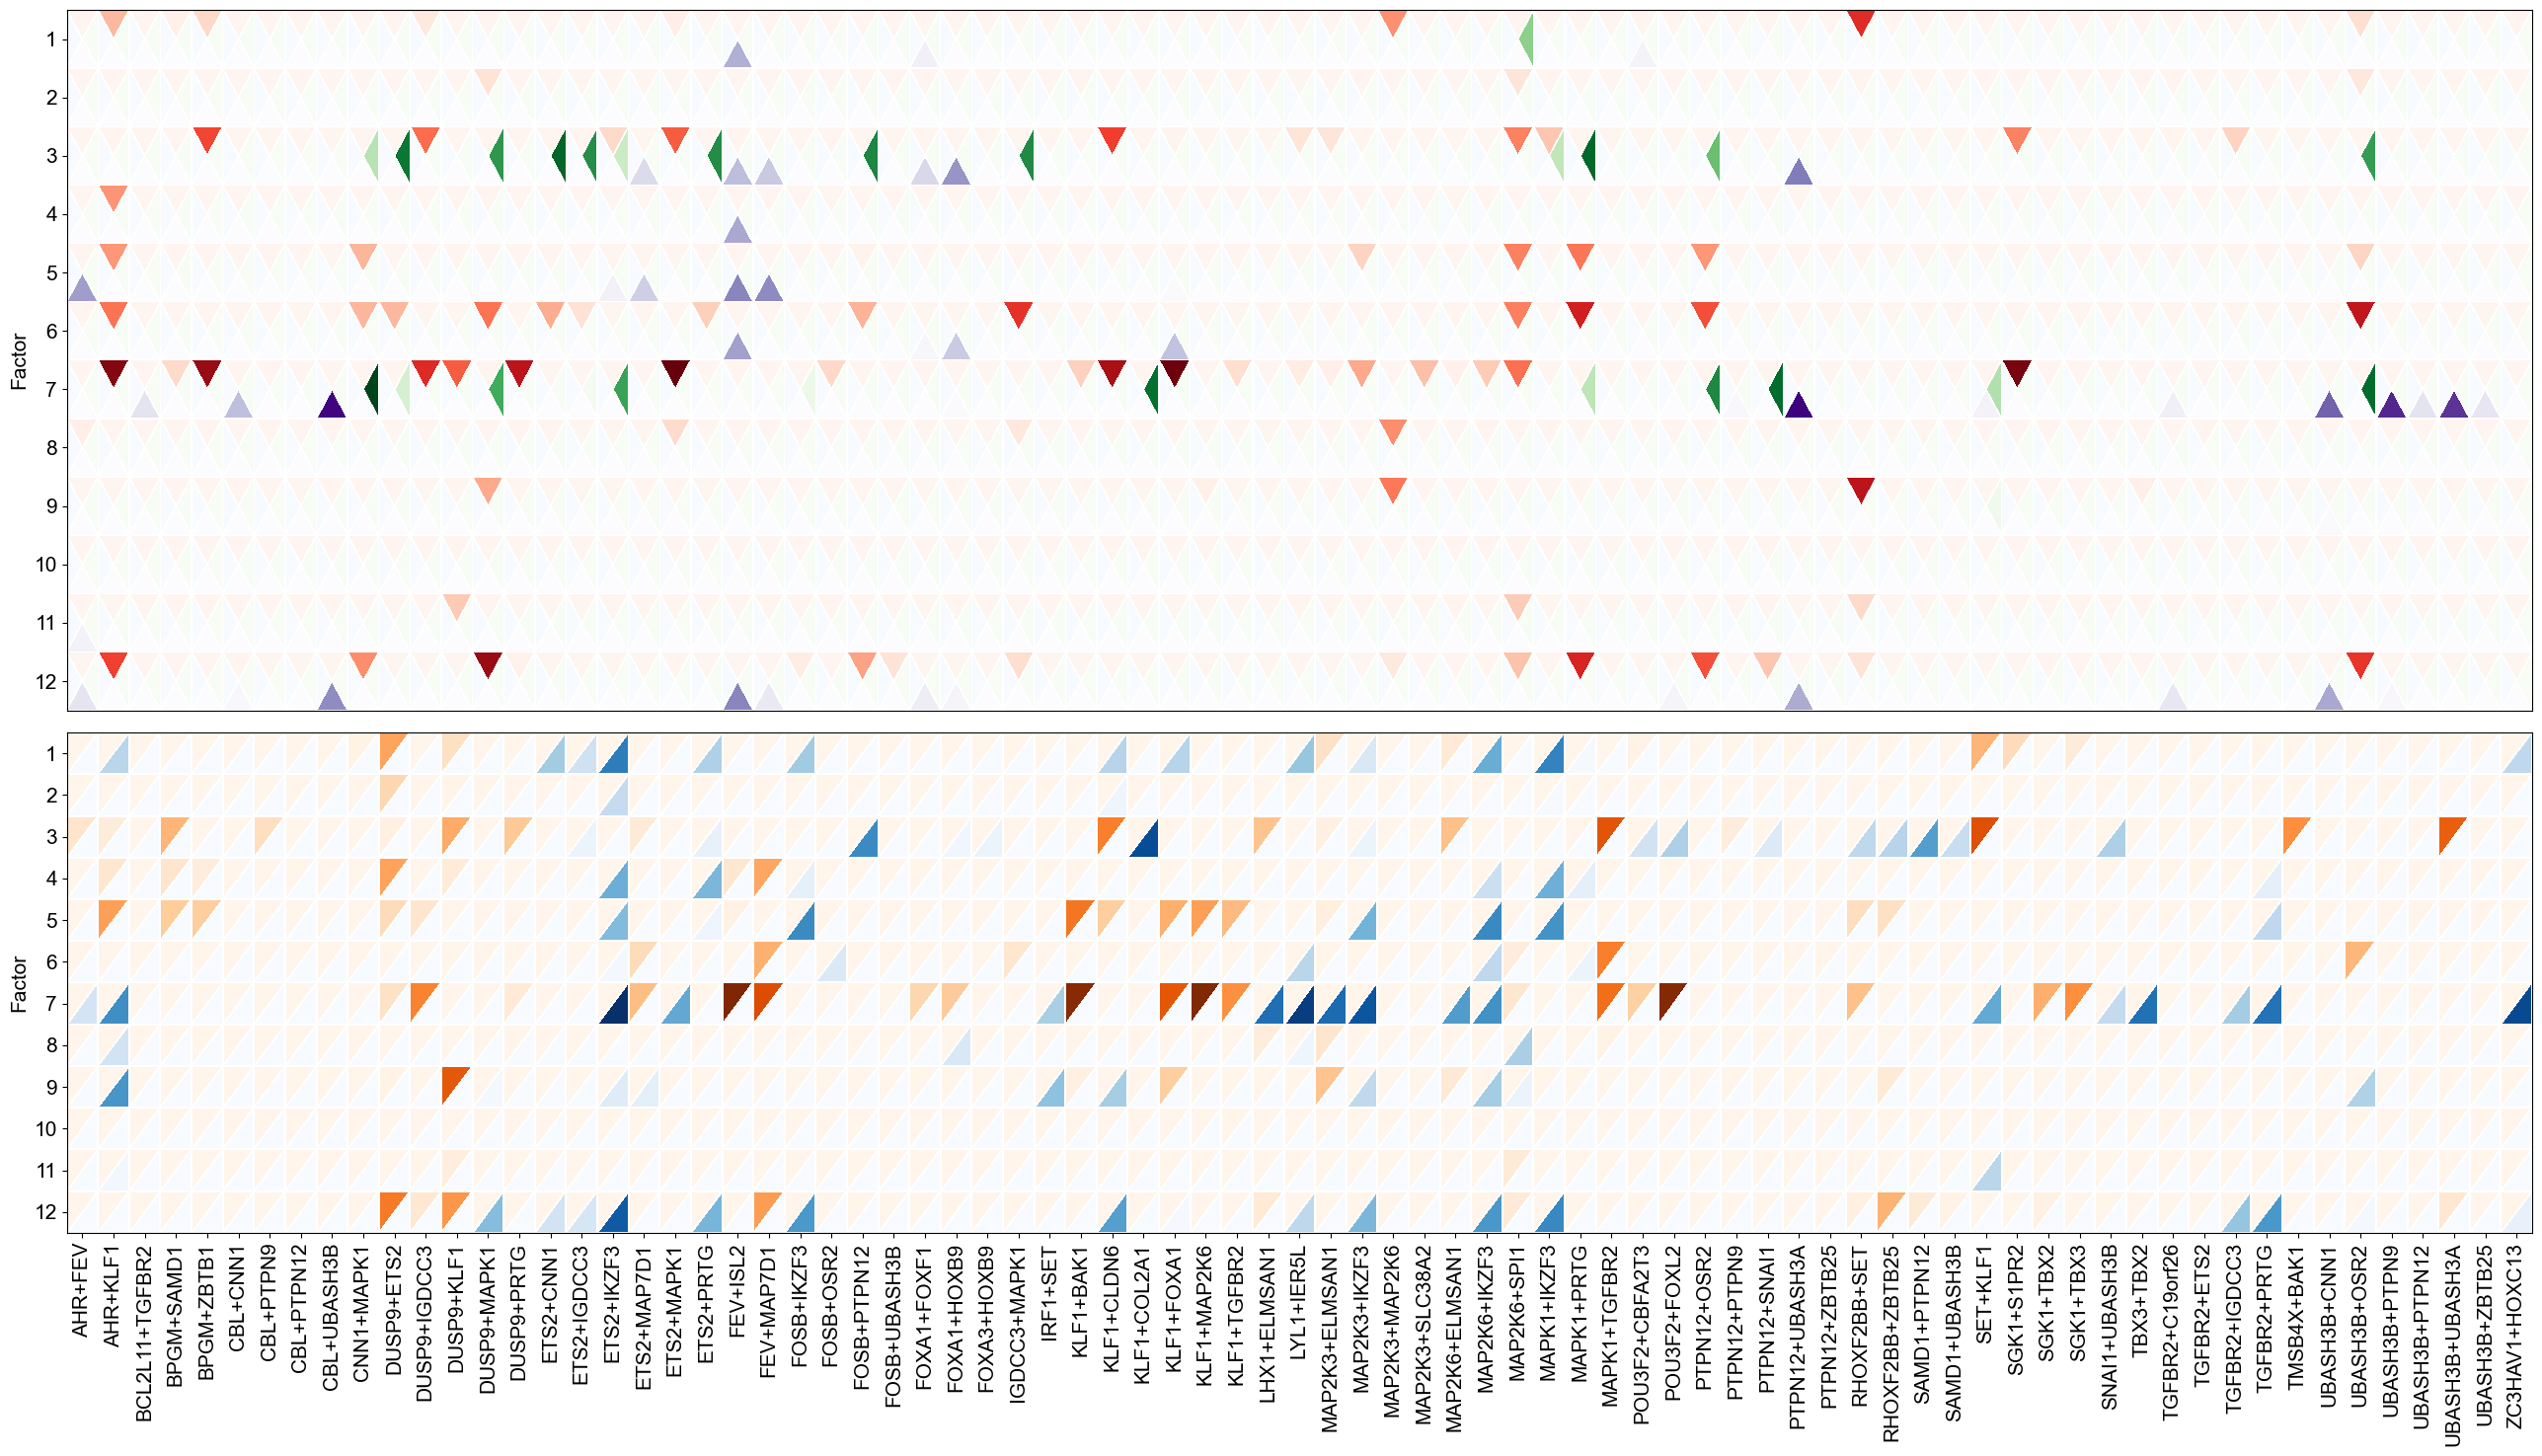

In [45]:
plotting.GI_triangle_plot(BF_all_res=BF_all_res,DM_all_res=DM_all_res,SY_all_res=SY_all_res,epiA_all_res=epiA_all_res,epiB_all_res=epiB_all_res,
                     target_list=target_list,show_factors='All',show_targets='All',vmin_1=0.2,vmin_2=0.3,
                     figsize=(26,15),save_path='all_figs/supp_figs',save=False)

<a id="8"></a> 
# 3 GI examples

<a id="9"></a> 
## 3.1 Domiant: DUSP9+ETS2 factor3

In [46]:
target='DUSP9+ETS2'
target1=target.split('+')[0]
target2=target.split('+')[1]
factor=2

In [47]:
subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
subset=subset[subset.obs.condition.isin(['control',target1,target2,target])]
ctrl_vec=np.array((subset[subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((subset[subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((subset[subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((subset[subset.obs.condition==target].X).mean(axis=0))[0,:]

In [48]:
#drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,a_vec-ctrl_vec+b_vec-ctrl_vec,ab_vec-ctrl_vec],index=['DUSP9','ETS2','DUSP9+ETS2','DUSP9/ETS2'],columns=subset.var_names)
drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec+b_vec-ctrl_vec)],index=[target1,target2,target,'Int'],columns=subset.var_names)

In [49]:
gene_idx=np.where(drawdf.loc['DUSP9']<0)[0]
drawdf=drawdf.iloc[:,gene_idx]

In [ ]:
# Calculate the metrics defined in [Norman et al]: delta_ab= c1*delta_a + c2*delta_a + epsilon:

In [50]:
regr_m = LinearRegression(fit_intercept=False)
x_m=np.column_stack((a_vec-ctrl_vec,b_vec-ctrl_vec))
y_m=ab_vec-ctrl_vec
regr_m.fit(np.asarray(x_m), np.asarray(y_m))
regr_m.coef_

array([0.8399531 , 0.30304492], dtype=float32)

In [51]:
np.sqrt(regr_m.coef_[0]**2+regr_m.coef_[1]**2)

0.892948751062659

In [52]:
all_res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format(target,factor)))
a_mean=all_res_ctrl.mean(axis=0)[0]
b_mean=all_res_ctrl.mean(axis=0)[1]
int_mean=all_res_ctrl.mean(axis=0)[2]

In [53]:
[a_mean,b_mean,int_mean] # tau_a, tau_b, tau_int averaged on all cells

[-0.8749189042271239, 1.3860048062994392, -0.8132920191197857]

### Difference in expression of high-loading genes in factor 3

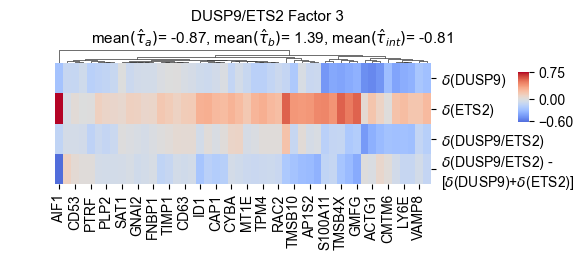

In [54]:
kws = dict(cbar_kws=dict(ticks=[-0.6, 0, 0.75], orientation='vertical'),figsize=(5.5, 2.5))
with plt.rc_context({'figure.figsize': (4, 2),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    plt.rc("font", size=10)
    g=sns.clustermap(drawdf,row_cluster=False,dendrogram_ratio=0.1,cmap=sns.color_palette("coolwarm", as_cmap=True),center=0,**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.95, 0.65, 0.02, 0.2])
    #g.ax_cbar.set_title('Expression',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    #g.ax_heatmap.set_xlabel('Genes in Factor '+str(factor+1))
    g.ax_heatmap.set_xlabel("")
    #g.ax_heatmap.set_xticks(labelsize=8)
    g.ax_heatmap.set_yticks(np.arange(4)+0.5,[r'$\delta$'+'('+target1+')',
                                              r'$\delta$'+'('+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')'+' -\n['+r'$\delta$'+'('+target1+')+'+r'$\delta$'+'('+target2+')]'])
    g.fig.suptitle(target1+'/'+target2+' '+'Factor '+str(factor+1)+' '+
                   '\n mean$(\\hat{\\tau}_a)$= -0.87, '+'mean$(\hat{\\tau}_b)$= 1.39, '+'mean$(\hat{\\tau}_{int})$= -0.81',y=1.1,x=0.5,fontsize=11) 
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','DM_gene_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

### Factor expression density plot

In [55]:
subset=treated[treated.obs.condition.isin(['control',target1,target2,target])]
subset=subset[:,str(factor)]
drawdf=pd.DataFrame([np.array(subset.X)[:,0],subset.obs.condition],index=['vals','condition'])
drawdf=drawdf.T

In [56]:
drawdf.groupby('condition').mean(0)

vals
condition           
DUSP9       6.054793
DUSP9+ETS2  6.635191
ETS2        8.344503
control     6.983867

In [57]:
grouped=drawdf.groupby('condition',sort=False)

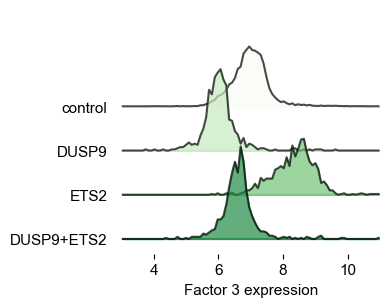

In [58]:
with plt.rc_context({'figure.figsize': (4, 3),'font.sans-serif':['Arial']}):
    fig,axs=joyplot(
        data=grouped, 
        xlabelsize=11,
        ylabelsize=11,
        by='condition',
        column=['vals'],
        legend=False,
        alpha=0.7,
        x_range=[3,11],
        #range_style='own',
        kind='normalized_counts',
        bins=90,
        #hist=True, bins=80,
        colormap=plt.get_cmap('Greens'),
        xlabels=True)
    #plt.rc("font", size=15)
    axs[-1].set_xlabel('Factor 3 expression',fontsize=11)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','DM_factor_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

<a id="10"></a> 
## 3.2 Buffering: MAPK1+PRTG factor12

In [59]:
target='MAPK1+PRTG'
target1=target.split('+')[0]
target2=target.split('+')[1]
factor=11

In [60]:
subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
subset=subset[subset.obs.condition.isin(['control',target1,target2,target])]
ctrl_vec=np.array((subset[subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((subset[subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((subset[subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((subset[subset.obs.condition==target].X).mean(axis=0))[0,:]

In [61]:
drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec+b_vec-ctrl_vec)],index=[target1,target2,target,'Int'],columns=subset.var_names)

In [62]:
regr_m = LinearRegression(fit_intercept=False)
x_m=np.column_stack((a_vec-ctrl_vec,b_vec-ctrl_vec))
y_m=ab_vec-ctrl_vec
regr_m.fit(np.asarray(x_m), np.asarray(y_m))
regr_m.coef_

array([0.3923986 , 0.46256137], dtype=float32)

In [63]:
np.sqrt(regr_m.coef_[0]**2+regr_m.coef_[1]**2)

0.6065803145761888

In [64]:
all_res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format(target,factor)))
a_mean=all_res_ctrl.mean(axis=0)[0]
b_mean=all_res_ctrl.mean(axis=0)[1]
int_mean=all_res_ctrl.mean(axis=0)[2]

In [65]:
[a_mean,b_mean,int_mean]

[-0.0758135422443082, -0.4450969853913581, 0.2792319356772812]

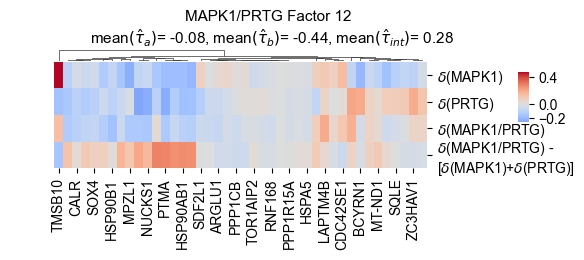

In [66]:
kws = dict(cbar_kws=dict(ticks=[-0.2, 0, 0.4], orientation='vertical'),figsize=(5.5, 2.5))
with plt.rc_context({'figure.figsize': (4, 2),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    g=sns.clustermap(drawdf,row_cluster=False,dendrogram_ratio=0.1,cmap=sns.color_palette("coolwarm", as_cmap=True),center=0,**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.95, 0.65, 0.02, 0.2])
    #g.ax_cbar.set_title('Expression',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    #g.ax_heatmap.set_xlabel('Genes in Factor '+str(factor+1))
    g.ax_heatmap.set_xlabel("")
    #g.ax_heatmap.set_xticks(labelsize=8)
    g.ax_heatmap.set_yticks(np.arange(4)+0.5,[r'$\delta$'+'('+target1+')',
                                              r'$\delta$'+'('+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')'+' -\n['+r'$\delta$'+'('+target1+')+'+r'$\delta$'+'('+target2+')]'])
    g.fig.suptitle(target1+'/'+target2+' '+'Factor '+str(factor+1)+' '+
                   '\n mean$(\\hat{\\tau}_a)$= -0.08, '+'mean$(\hat{\\tau}_b)$= -0.44, '+'mean$(\hat{\\tau}_{int})$= 0.28',y=1.1,x=0.5,fontsize=11) 
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','BF_gene_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

In [67]:
subset=treated[treated.obs.condition.isin(['control',target1,target2,target])]
subset=subset[:,str(factor)]
drawdf=pd.DataFrame([np.array(subset.X)[:,0],subset.obs.condition],index=['vals','condition'])
drawdf=drawdf.T

In [68]:
cat_type = pd.CategoricalDtype(categories=['control', target1, target2,target])
drawdf.condition=drawdf.condition.astype(cat_type)

In [69]:
drawdf.groupby('condition').mean(0)

vals
condition           
control     9.223189
MAPK1       9.097943
PRTG        8.766797
MAPK1+PRTG  8.948322

In [70]:
grouped=drawdf.groupby('condition',sort=False)

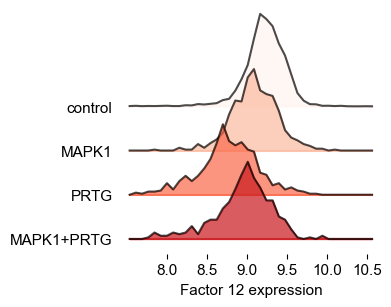

In [71]:
with plt.rc_context({'figure.figsize': (4, 3),'font.sans-serif':['Arial']}):
    fig,axs=joyplot(
        data=drawdf,
        xlabelsize=11,
        ylabelsize=11,
        by='condition',
        column=['vals'],
        legend=False,
        alpha=0.7,
        x_range=[7.5,10.6],
        #range_style='own',
        kind='normalized_counts',
        bins=40,
        #hist=True, bins=80,
        colormap=plt.get_cmap('Reds'),
        xlabels=True)
    axs[-1].set_xlabel('Factor 12 expression',fontsize=11)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','BF_factor_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

<a id="11"></a> 
## 3.3 Synergistic: CBL+UBASH3B factor7

In [73]:
target='CBL+UBASH3B'
target1=target.split('+')[0]
target2=target.split('+')[1]
factor=6

In [74]:
subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
subset=subset[subset.obs.condition.isin(['control',target1,target2,target])]
ctrl_vec=np.array((subset[subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((subset[subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((subset[subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((subset[subset.obs.condition==target].X).mean(axis=0))[0,:]

In [75]:
#drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,a_vec-ctrl_vec+b_vec-ctrl_vec,ab_vec-ctrl_vec],index=['DUSP9','ETS2','DUSP9+ETS2','DUSP9/ETS2'],columns=subset.var_names)
drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec+b_vec-ctrl_vec)],index=[target1,target2,target,'Int'],columns=subset.var_names)

In [76]:
regr_m = LinearRegression(fit_intercept=False)
x_m=np.column_stack((a_vec-ctrl_vec,b_vec-ctrl_vec))
y_m=ab_vec-ctrl_vec
regr_m.fit(np.asarray(x_m), np.asarray(y_m))
regr_m.coef_

array([1.4911443, 1.4820222], dtype=float32)

In [77]:
np.sqrt(regr_m.coef_[0]**2+regr_m.coef_[1]**2)

2.102356064803324

In [78]:
all_res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format(target,factor)))
a_mean=all_res_ctrl.mean(axis=0)[0]
b_mean=all_res_ctrl.mean(axis=0)[1]
int_mean=all_res_ctrl.mean(axis=0)[2]

In [79]:
[a_mean,b_mean,int_mean]

[1.770726823541639, 1.1638955530650938, 1.7420639083854768]

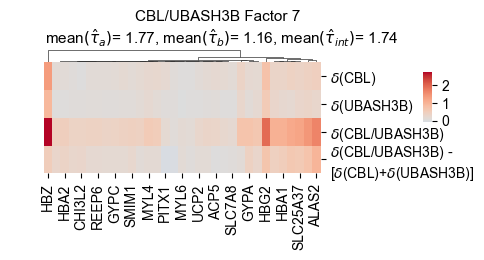

In [80]:
kws = dict(cbar_kws=dict(ticks=[ 0, 1,2], orientation='vertical'),figsize=(4.5, 2.5))
with plt.rc_context({'figure.figsize': (4, 2),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    g=sns.clustermap(drawdf,row_cluster=False,dendrogram_ratio=0.1,cmap=sns.color_palette("coolwarm", as_cmap=True),center=0,**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.95, 0.65, 0.02, 0.2])
    #g.ax_cbar.set_title('Expression',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    #g.ax_heatmap.set_xlabel('Genes in Factor '+str(factor+1))
    g.ax_heatmap.set_xlabel("")
    #g.ax_heatmap.set_xticks(labelsize=8)
    g.ax_heatmap.set_yticks(np.arange(4)+0.5,[r'$\delta$'+'('+target1+')',
                                              r'$\delta$'+'('+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')'+' -\n['+r'$\delta$'+'('+target1+')+'+r'$\delta$'+'('+target2+')]'])
    g.fig.suptitle(target1+'/'+target2+' '+'Factor '+str(factor+1)+' '+
                   '\n mean$(\\hat{\\tau}_a)$= 1.77, '+'mean$(\hat{\\tau}_b)$= 1.16, '+'mean$(\hat{\\tau}_{int})$= 1.74',y=1.1,x=0.5,fontsize=11) 
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','SY_gene_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

In [81]:
subset=treated[treated.obs.condition.isin(['control',target1,target2,target])]
subset=subset[:,str(factor)]
drawdf=pd.DataFrame([np.array(subset.X)[:,0],subset.obs.condition],index=['vals','condition'])
drawdf=drawdf.T

In [82]:
cat_type = pd.CategoricalDtype(categories=['control', target1, target2,target])
drawdf.condition=drawdf.condition.astype(cat_type)

In [83]:
drawdf.groupby('condition').mean(0)

vals
condition            
control      4.196289
CBL          5.940123
UBASH3B      5.353681
CBL+UBASH3B  9.046281

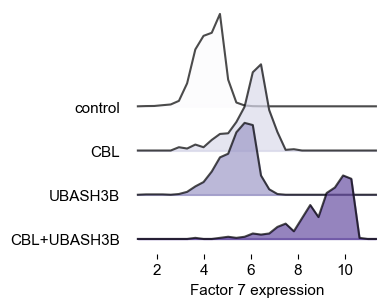

In [84]:
with plt.rc_context({'figure.figsize': (4, 3),'font.sans-serif':['Arial']}):
    fig,axs=joyplot(
        data=drawdf, 
        xlabelsize=11,
        ylabelsize=11,
        by='condition',
        column=['vals'],
        legend=False,
        alpha=0.7,
        x_range=[1,11.5],
        #range_style='own',
        kind='normalized_counts',
        bins=30,
        #hist=True, bins=80,
        colormap=plt.get_cmap('Purples'),
        xlabels=True)
    axs[-1].set_xlabel('Factor 7 expression',fontsize=11)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','SY_factor_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

<a id="12"></a> 
## 3.4 Epistasis: MAP2K3+IKZF3

In [85]:
target='MAP2K3+IKZF3'
target1=target.split('+')[0]
target2=target.split('+')[1]
factor=6

In [86]:
subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
subset=subset[subset.obs.condition.isin(['control',target1,target2,target])]
ctrl_vec=np.array((subset[subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((subset[subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((subset[subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((subset[subset.obs.condition==target].X).mean(axis=0))[0,:]

In [87]:
#drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,a_vec-ctrl_vec+b_vec-ctrl_vec,ab_vec-ctrl_vec],index=['DUSP9','ETS2','DUSP9+ETS2','DUSP9/ETS2'],columns=subset.var_names)
drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(b_vec-ctrl_vec)],index=[target1,target2,target,'Int'],columns=subset.var_names)

In [88]:
regr_m = LinearRegression(fit_intercept=False)
x_m=np.column_stack((a_vec-ctrl_vec,b_vec-ctrl_vec))
y_m=ab_vec-ctrl_vec
regr_m.fit(np.asarray(x_m), np.asarray(y_m))
regr_m.coef_

array([0.97483075, 0.90798926], dtype=float32)

In [89]:
np.sqrt(regr_m.coef_[0]**2+regr_m.coef_[1]**2)

1.3321934871892898

In [90]:
all_res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format(target,factor)))
a_mean=all_res_ctrl.mean(axis=0)[0]
b_mean=all_res_ctrl.mean(axis=0)[1]
int_mean=all_res_ctrl.mean(axis=0)[2]

In [91]:
[a_mean,b_mean,int_mean]

[0.20542571170612828, 5.03816753960367, -0.6130460223705531]

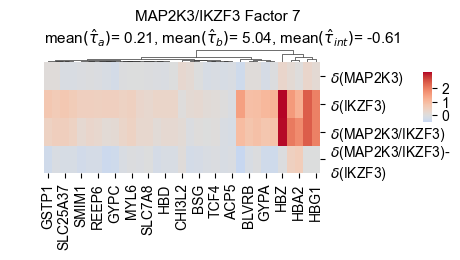

In [92]:
kws = dict(cbar_kws=dict(ticks=[ -0, 1,2], orientation='vertical'),figsize=(4.5, 2.5))
with plt.rc_context({'figure.figsize': (4, 2),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    g=sns.clustermap(drawdf,row_cluster=False,dendrogram_ratio=0.1,cmap=sns.color_palette("coolwarm", as_cmap=True),center=0,**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.95, 0.65, 0.02, 0.2])
    #g.ax_cbar.set_title('Expression',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    #g.ax_heatmap.set_xlabel('Genes in Factor '+str(factor+1))
    g.ax_heatmap.set_xlabel("")
    #g.ax_heatmap.set_xticks(labelsize=8)
    g.ax_heatmap.set_yticks(np.arange(4)+0.5,[r'$\delta$'+'('+target1+')',
                                              r'$\delta$'+'('+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')-\n'+r'$\delta$'+'('+target2+')'])
    g.fig.suptitle(target1+'/'+target2+' '+'Factor '+str(factor+1)+' '+
                   '\n mean$(\\hat{\\tau}_a)$= 0.21, '+'mean$(\hat{\\tau}_b)$= 5.04, '+'mean$(\hat{\\tau}_{int})$= -0.61',y=1.1,x=0.5,fontsize=11) 
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','epi_gene_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

In [93]:
subset=treated[treated.obs.condition.isin(['control',target1,target2,target])]
subset=subset[:,str(factor)]
drawdf=pd.DataFrame([np.array(subset.X)[:,0],subset.obs.condition],index=['vals','condition'])
drawdf=drawdf.T

In [94]:
cat_type = pd.CategoricalDtype(categories=['control', target1, target2,target])
drawdf.condition=drawdf.condition.astype(cat_type)

In [95]:
drawdf.groupby('condition').mean(0)

vals
condition             
control       4.196289
MAP2K3        4.397840
IKZF3         9.518985
MAP2K3+IKZF3  8.920175

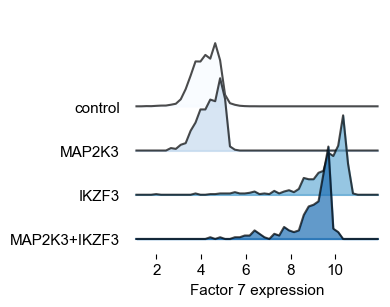

In [96]:
with plt.rc_context({'figure.figsize': (4, 3),'font.sans-serif':['Arial']}):
    fig,axs=joyplot(
        data=drawdf, 
        xlabelsize=11,
        ylabelsize=11,
        by='condition',
        column=['vals'],
        legend=False,
        alpha=0.7,
        x_range=[1,12],
        #range_style='own',
        kind='normalized_counts',
        bins=50,
        #hist=True, bins=80,
        colormap=plt.get_cmap('Blues'),
        xlabels=True)
    axs[-1].set_xlabel('Factor 7 expression',fontsize=11)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','epi_factor_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

<a id="13"></a> 
# 4 Heterogeneous interactions

As a single cell resolution method, scCAPE enables the exploration of potential heterogeneity in genetic interactions.

<a id="14"></a> 
## 4.1 CBL/CNN1 Factor 7

### Synergistic significant UMAP

In [97]:
res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format('CBL+CNN1',6)))

In [98]:
res_ctrl_df=pd.DataFrame(res_ctrl,columns=['tau_a','tau_b','tau_int','pval_a','pval_b','pval_int',
                                            'sign_sig_a','sign_sig_b','sign_sig_int','pval_SY','pval_BF','pval_DM',
                                            'pval_epia','pval_epib','sig_SY','sig_BF','sig_DM','sig_epia','sig_epib',
                                            'sig_RD','sig_NE'])

In [99]:
np.mean(res_ctrl_df['sig_SY']) # Only 46% control cells are significant

0.46416428668570653

In [100]:
target='CBL+CNN1'
t1=target.split('+')[0]
t2=target.split('+')[1]
adata_ctrl_subset=adata[adata.obs['condition'].isin([t1,t2, target, 'control'])]
adata_ctrl_subset=adata_ctrl_subset[adata_ctrl_subset.obs.control==1]

In [101]:
adata_ctrl_subset.obs['sig_SY']=pd.Categorical([str(int(i)) for i in res_ctrl_df['sig_SY'].values],categories=['0','1'])
adata_ctrl_subset.uns['sig_SY_colors']=['lightgrey','purple']

C:\Users\17794\AppData\Local\Temp\ipykernel_24372\1924705381.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ctrl_subset.obs['sig_SY']=pd.Categorical([str(int(i)) for i in res_ctrl_df['sig_SY'].values],categories=['0','1'])


C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


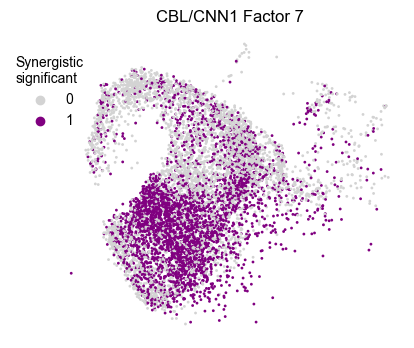

In [102]:
with plt.rc_context({'figure.figsize': (4.5, 4),'font.sans-serif':['Arial']}):
    fig=sc.pl.umap(adata_ctrl_subset,color='sig_SY',frameon=False,title='CBL/CNN1 Factor 7',return_fig=True)
    ax=fig.axes[0]
    ax.legend(loc = 'center left', bbox_to_anchor = (-0.15, 0.8),title='Synergistic\nsignificant',frameon=False)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','CBL_CNN1_SY_UMAP.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

### Compare with cell cycle phases

In [103]:
cell_cycle_genes = [x.strip() for x in open(os.path.join(dataset_name,'regev_lab_cell_cycle_genes.txt'))]
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [104]:
sc.tl.score_genes_cell_cycle(adata_ctrl_subset, s_genes=s_genes, g2m_genes=g2m_genes)

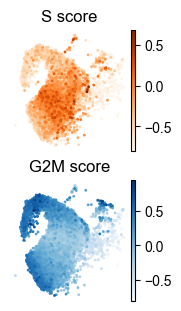

In [105]:
with plt.rc_context({'figure.figsize': (1.7, 3),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,1,constrained_layout=True)
    sc.pl.umap(adata_ctrl_subset,color='S_score',title='S score',cmap='Oranges',vmin=-0.8,frameon=False,ax=axs[0],show=False)
    sc.pl.umap(adata_ctrl_subset,color='G2M_score',title='G2M score',cmap='Blues',vmin=-0.8,frameon=False,ax=axs[1],show=False)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','Cycle_phase_UMAP_res2.svg'), dpi=1000, bbox_inches="tight",transparent=True)
    plt.show()

Significant cells were enriched in the S phase of the cell cycle, indicating a stronger influence of synergistic effects in driving erythroid differentiation during this stage.

### Using MELD and VFC to identify synergy-significant (nonsignificant) enriched subclusters

In [106]:
res=sccape.CF_GI_single_target_single_factor(dataset_name=dataset_name,target='CBL+CNN1', factor=6, basal=basal,treated=treated, adata=adata, 
                                   pert_key='condition', n_estimators=1000,min_samples_leaf=5,
                                      random_state=0,one_side=False,alpha=0.05,return_ctrl=False,save=False)

Finish GI calculation in target=CBL+CNN1 factor=6


In [107]:
res_df=pd.DataFrame(res,columns=['tau_a','tau_b','tau_int','pval_a','pval_b','pval_int',
                                            'sign_sig_a','sign_sig_b','sign_sig_int','pval_SY','pval_BF','pval_DM',
                                            'pval_epia','pval_epib','sig_SY','sig_BF','sig_DM','sig_epia','sig_epib',
                                            'sig_RD','sig_NE'])

In [108]:
target='CBL+CNN1'
t1=target.split('+')[0]
t2=target.split('+')[1]
subset=basal[basal.obs['condition'].isin([t1,t2, target, 'control'])]

In [109]:
subset.obs['sig_SY']=pd.Categorical([str(int(i)) for i in res_df['sig_SY'].values],categories=['0','1'])
subset.uns['sig_SY_colors']=['lightgrey','purple']

C:\Users\17794\AppData\Local\Temp\ipykernel_24372\3906021626.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs['sig_SY']=pd.Categorical([str(int(i)) for i in res_df['sig_SY'].values],categories=['0','1'])


C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


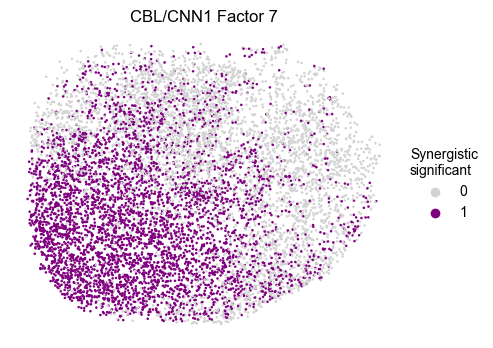

In [110]:
with plt.rc_context({'figure.figsize': (5, 4),'font.sans-serif':['Arial']}):
    fig=sc.pl.umap(subset,color='sig_SY',frameon=False,title='CBL/CNN1 Factor 7',return_fig=True)
    ax=fig.axes[0]
    ax.legend_.set_title('Synergistic\nsignificant')
    plt.show()

In [111]:
import meld
import graphtools as gt

In [112]:
sc.tl.pca(subset)

In [113]:
data_pca=subset.obsm['X_pca']

In [114]:
G = gt.Graph(data_pca, knn=int(20), use_pygsp=True)

In [115]:
meld_op = meld.MELD(beta=50)
sample_densities = meld_op.fit_transform(G, sample_labels=subset.obs['sig_SY'])

Building graph on 8815 samples and 19 features.


In [116]:
sample_likelihoods=pd.DataFrame(sample_densities.values/(sample_densities.values.sum(axis=1).reshape(-1,1)),columns=['0','1'])

In [117]:
subset.obs['MELD']=sample_likelihoods['1'].values

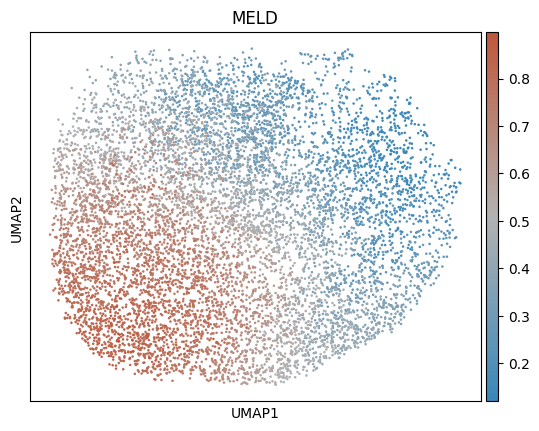

In [118]:
sc.pl.umap(subset,color='MELD',cmap=meld.get_meld_cmap())

In [119]:
np.random.seed(0)
curr_G = gt.Graph(data_pca, use_pygsp=True)
curr_G.compute_fourier_basis()
curr_sample_labels = res_df['sig_SY'].values
curr_likelihood =subset.obs.MELD.values
curr_vfc = meld.VertexFrequencyCluster(n_clusters = 3)
curr_vfc.fit_transform(curr_G, curr_sample_labels, curr_likelihood)

In [120]:
subset.obs['vfc'] = [str(clust) for clust in curr_vfc.predict(4)]

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


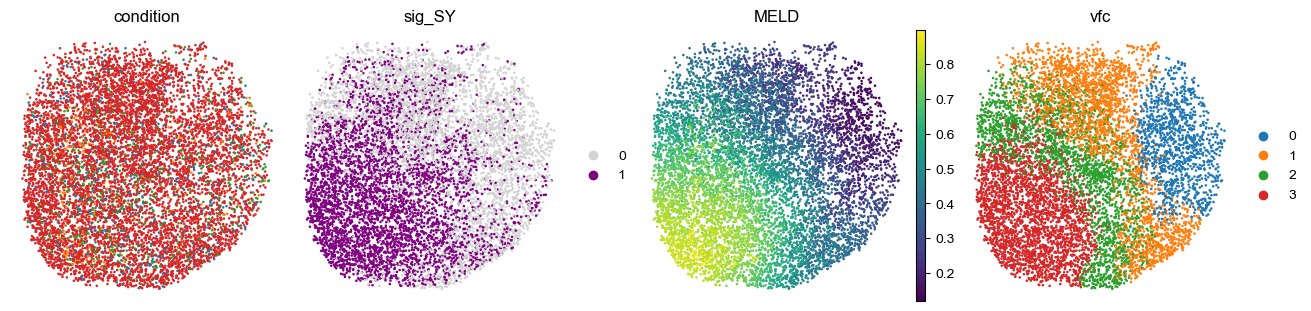

In [136]:
with plt.rc_context({'figure.figsize': (13, 3),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1,4,constrained_layout=True)
    sc.pl.umap(subset,color='condition',title='condition',frameon=False,legend_loc='none',ax=axs[0],show=False)
    sc.pl.umap(subset,color='sig_SY',title='sig_SY',frameon=False,ax=axs[1],show=False)
    sc.pl.umap(subset,color='MELD',title='MELD',frameon=False,ax=axs[2],show=False)
    sc.pl.umap(subset,color='vfc',title='vfc',frameon=False,ax=axs[3],show=False)
    plt.show()

In [137]:
subset.obs['tau_a']=res_df['tau_a'].values
subset.obs['tau_b']=res_df['tau_b'].values
subset.obs['tau_int']=res_df['tau_int'].values
subset.obs['pval_SY']=res_df['pval_SY'].values

In [138]:
subset.write(os.path.join(dataset_name,'CausalForests','CBL_CNN1_SUBSET.h5ad'))

In [139]:
subset=sc.read(os.path.join(dataset_name,'CausalForests','CBL_CNN1_SUBSET.h5ad'))

In [140]:
adata_ctrl_subset.obs['vfc']=subset[adata_ctrl_subset.obs_names].obs['vfc']

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


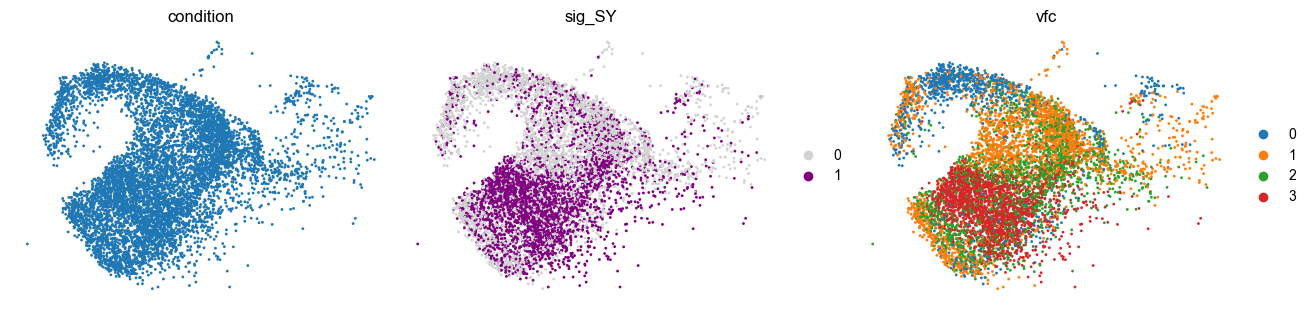

In [141]:
with plt.rc_context({'figure.figsize': (13, 3),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1,3,constrained_layout=True)
    sc.pl.umap(adata_ctrl_subset,color='condition',title='condition',frameon=False,legend_loc='none',ax=axs[0],show=False)
    sc.pl.umap(adata_ctrl_subset,color='sig_SY',title='sig_SY',frameon=False,ax=axs[1],show=False)
    sc.pl.umap(adata_ctrl_subset,color='vfc',title='vfc',frameon=False,ax=axs[2],show=False)
    plt.show()

Subcluster 3: Significant enriched, subcluster 0: non-significant enriched

### Calculate average tau and pval on these two subclusters

In [142]:
target='CBL+CNN1'
target1=target.split('+')[0]
target2=target.split('+')[1]
factor=6

In [143]:
selected_cells=subset[subset.obs.vfc=='0'].obs.index
draw_subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
draw_subset=draw_subset[selected_cells]
ctrl_vec=np.array((draw_subset[draw_subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((draw_subset[draw_subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((draw_subset[draw_subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((draw_subset[draw_subset.obs.condition==target].X).mean(axis=0))[0,:]
drawdf_clust0=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec+b_vec-ctrl_vec)],index=[target1,target2,target,'Int'],columns=draw_subset.var_names)

In [144]:
int_mean_clust0=((subset[subset.obs.vfc=='0']).obs.tau_int).mean()
pval_mean_clust0=((subset[subset.obs.vfc=='0']).obs.pval_SY).mean()
[int_mean_clust0,pval_mean_clust0] # average tau, pval on subcluster 0

[0.4622452334925753, 0.3194310249080541]

In [145]:
selected_cells=subset[subset.obs.vfc=='3'].obs.index
draw_subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
draw_subset=draw_subset[selected_cells]
ctrl_vec=np.array((draw_subset[draw_subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((draw_subset[draw_subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((draw_subset[draw_subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((draw_subset[draw_subset.obs.condition==target].X).mean(axis=0))[0,:]
drawdf_clust3=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec+b_vec-ctrl_vec)],index=[target1,target2,target,'Int'],columns=draw_subset.var_names)

In [146]:
int_mean_clust3=((subset[subset.obs.vfc=='3']).obs.tau_int).mean()
pval_mean_clust3=((subset[subset.obs.vfc=='3']).obs.pval_SY).mean()
[int_mean_clust3,pval_mean_clust3] # average tau, pval on subcluster 3

[1.113380976430826, 0.01600533217300252]

### Calculate the average expression of high-loading genes in factor 7 on these two subclusters to validate the findings

In [147]:
compare_int_df=pd.DataFrame([drawdf_clust0.loc['Int'].values,drawdf_clust3.loc['Int'].values],columns=drawdf_clust0.columns)
#new_columns =compare_int_df.columns[compare_int_df.mean(axis=0).argsort()]
new_columns = compare_int_df.columns[compare_int_df.loc[compare_int_df.last_valid_index()].argsort()]
compare_int_df=compare_int_df[new_columns]
compare_int_df['clust']=['0','3']
compare_int_df=pd.melt(compare_int_df,id_vars=['clust'])
compare_int_df

clust gene_name     value
0      0       HBZ -0.646273
1      3       HBZ -0.204250
2      0      NENF -0.152101
3      3      NENF -0.138331
4      0     PITX1 -0.436762
..   ...       ...       ...
61     3     ALAS2  0.550706
62     0  SLC25A37  0.309418
63     3  SLC25A37  0.590909
64     0      HBG1  0.087333
65     3      HBG1  0.652319

[66 rows x 3 columns]

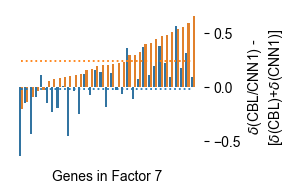

In [148]:
with plt.rc_context({'figure.figsize': (2.5,2),'font.sans-serif':['Arial']}):
    ax=sns.barplot(x = 'gene_name',
                y = 'value',
                hue = 'clust',
                data = compare_int_df)
    ax.legend_.remove()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    sns.despine(bottom = True, left = True)
    plt.ylabel(r'$\delta$'+'('+target1+'/'+target2+')'+' -\n['+r'$\delta$'+'('+target1+')+'+r'$\delta$'+'('+target2+')]')
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.xlabel('Genes in Factor 7')
    weights=gene_loading_df.loc[6,adata.var_names[genes_do_go[str(6)]]].values
    plt.plot([0, drawdf_clust0.shape[1]-1], [np.average(drawdf_clust0.loc['Int'].values,weights=weights), np.average(drawdf_clust0.loc['Int'].values,weights=weights)],color=sns.color_palette()[0], linewidth=1.3,linestyle='dotted')
    plt.plot([0, drawdf_clust3.shape[1]-1], [np.average(drawdf_clust3.loc['Int'].values,weights=weights), np.average(drawdf_clust3.loc['Int'].values,weights=weights)],color=sns.color_palette()[1], linewidth=1.3,linestyle='dotted')
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','CBL_CNN1_gene_compare_res.svg'), dpi=1000, bbox_inches="tight",transparent=True)
    plt.show()

### Supplementary figures

In [149]:
target='CBL+CNN1'
t1=target.split('+')[0]
t2=target.split('+')[1]
subset=basal[basal.obs['condition'].isin([t1,t2, target, 'control'])]

In [150]:
subset.uns['condition_colors']=['#1f77b4', '#ff7f0e', '#2ca02c', 'grey']

C:\Users\17794\AppData\Roaming\Python\Python39\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [151]:
subset.obs['tau_a']=res_df['tau_a'].values
subset.obs['tau_b']=res_df['tau_b'].values
subset.obs['tau_int']=res_df['tau_int'].values
subset.obs['pval_SY']=res_df['pval_SY'].values
subset.obs['sig_SY']=pd.Categorical([str(int(i)) for i in res_df['sig_SY'].values],categories=['0','1'])
subset.uns['sig_SY_colors']=['lightgrey','purple']

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


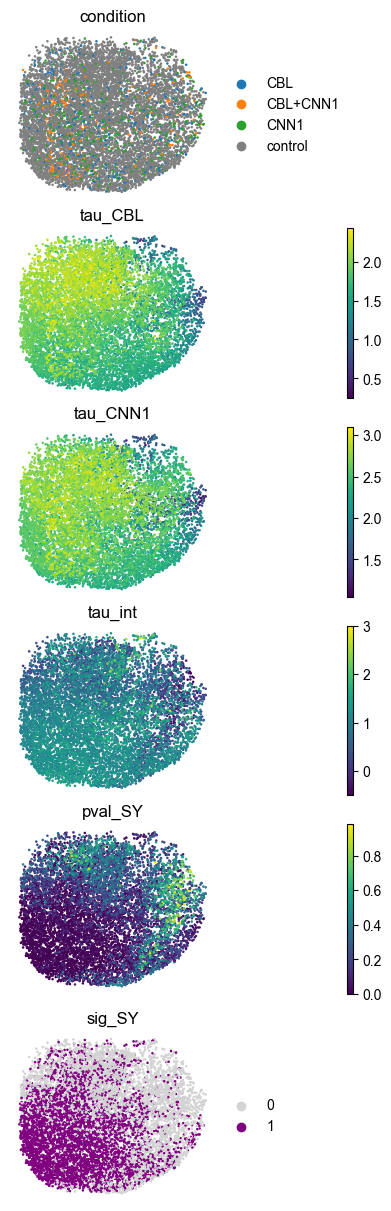

In [152]:
with plt.rc_context({'figure.figsize': (3.8, 12),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(6,1,constrained_layout=True)
    sc.pl.umap(subset,color='condition',title='condition',frameon=False,ax=axs[0],show=False)
    sc.pl.umap(subset,color='tau_a',title='tau_CBL',frameon=False,ax=axs[1],show=False)
    sc.pl.umap(subset,color='tau_b',title='tau_CNN1',frameon=False,ax=axs[2],show=False)
    sc.pl.umap(subset,color='tau_int',title='tau_int',vmin=-0.5,vmax=3,frameon=False,ax=axs[3],show=False)
    sc.pl.umap(subset,color='pval_SY',title='pval_SY',frameon=False,ax=axs[4],show=False)
    sc.pl.umap(subset,color='sig_SY',title='sig_SY',frameon=False,ax=axs[5],show=False)
    #plt.savefig(os.path.join('all_figs','supp_figs','CBL_CNN1_basal_res.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

<a id="15"></a> 
## 4.2 Other erythroid differentiation drivers, Factor 7

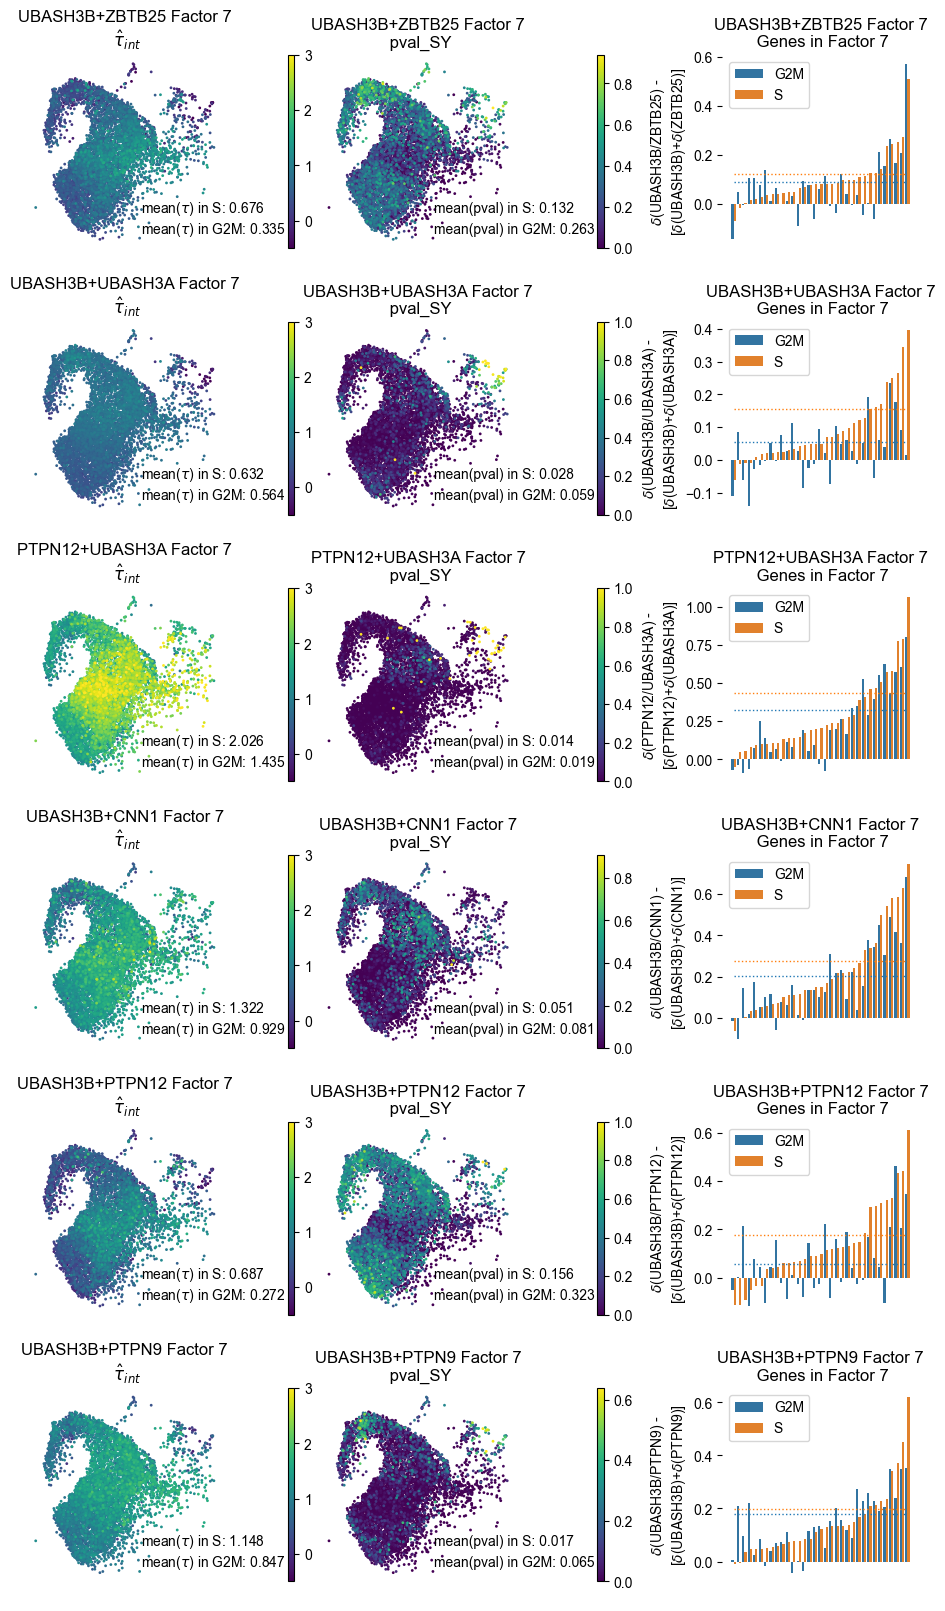

In [156]:
target_list=['UBASH3B+ZBTB25','UBASH3B+UBASH3A','PTPN12+UBASH3A','UBASH3B+CNN1','UBASH3B+PTPN12','UBASH3B+PTPN9']
with plt.rc_context({'figure.figsize': (9, 16),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(6,3,constrained_layout=True)
    for i in range(len(target_list)):
        target=target_list[i]
        factor=6
        res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format(target,factor)))
        res_ctrl_df=pd.DataFrame(res_ctrl,columns=['tau_a','tau_b','tau_int','pval_a','pval_b','pval_int',
                                                    'sign_sig_a','sign_sig_b','sign_sig_int','pval_SY','pval_BF','pval_DM',
                                                    'pval_epia','pval_epib','sig_SY','sig_BF','sig_DM','sig_epia','sig_epib',
                                                    'sig_RD','sig_NE'])
        t1=target.split('+')[0]
        t2=target.split('+')[1]
        subset=adata[adata.obs['condition'].isin([t1,t2, target, 'control'])]
        
        adata_ctrl_subset=(subset[subset.obs.control==1]).copy()
        adata_ctrl_subset.obs['tau_int']=res_ctrl_df['tau_int'].values
        adata_ctrl_subset.obs['pval_SY']=res_ctrl_df['pval_SY'].values
    
        int_mean_clust_S=((adata_ctrl_subset[adata_ctrl_subset.obs.phase=='S']).obs.tau_int).mean()
        pval_mean_clust_S=((adata_ctrl_subset[adata_ctrl_subset.obs.phase=='S']).obs.pval_SY).mean()
        
        int_mean_clust_G2M=((adata_ctrl_subset[adata_ctrl_subset.obs.phase=='G2M']).obs.tau_int).mean()
        pval_mean_clust_G2M=((adata_ctrl_subset[adata_ctrl_subset.obs.phase=='G2M']).obs.pval_SY).mean()
        
        selected_cells=subset[subset.obs.phase=='S'].obs.index
        draw_subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
        draw_subset=draw_subset[selected_cells]
        ctrl_vec=np.array((draw_subset[draw_subset.obs.condition=='control'].X).mean(axis=0))[0,:]
        a_vec=np.array((draw_subset[draw_subset.obs.condition==t1].X).mean(axis=0))[0,:]
        b_vec=np.array((draw_subset[draw_subset.obs.condition==t2].X).mean(axis=0))[0,:]
        ab_vec=np.array((draw_subset[draw_subset.obs.condition==target].X).mean(axis=0))[0,:]

        drawdf_clust_S=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec+b_vec-ctrl_vec)],
                                    index=[t1,t2,target,'Int'],columns=draw_subset.var_names)

        selected_cells=subset[subset.obs.phase=='G2M'].obs.index
        draw_subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
        draw_subset=draw_subset[selected_cells]
        
        ctrl_vec=np.array((draw_subset[draw_subset.obs.condition=='control'].X).mean(axis=0))[0,:]
        a_vec=np.array((draw_subset[draw_subset.obs.condition==t1].X).mean(axis=0))[0,:]
        b_vec=np.array((draw_subset[draw_subset.obs.condition==t2].X).mean(axis=0))[0,:]
        ab_vec=np.array((draw_subset[draw_subset.obs.condition==target].X).mean(axis=0))[0,:]

        drawdf_clust_G2M=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec+b_vec-ctrl_vec)],
                                      index=[t1,t2,target,'Int'],columns=draw_subset.var_names)
        
        compare_int_df=pd.DataFrame([drawdf_clust_G2M.loc['Int'].values,drawdf_clust_S.loc['Int'].values],columns=drawdf_clust_S.columns)
        new_columns = compare_int_df.columns[compare_int_df.loc[compare_int_df.last_valid_index()].argsort()]
        compare_int_df=compare_int_df[new_columns]
        compare_int_df['clust']=['G2M','S']
        compare_int_df=pd.melt(compare_int_df,id_vars=['clust'])

        sc.pl.umap(adata_ctrl_subset,color='tau_int',frameon=False,title=target+' Factor 7\n '+r'$\hat{\tau}_{int}$',
                   vmin=-0.5,vmax=3,ax=axs[i][0],show=False)
        sc.pl.umap(adata_ctrl_subset,color='pval_SY',frameon=False,title=target+' Factor 7\n '+'pval_SY',ax=axs[i][1],show=False)
        axs[i][0].text(2.5,-2.7,r'mean($\tau$) in S: {}'.format(np.round(int_mean_clust_S,3)))
        axs[i][0].text(2.5,-4.2,r'mean($\tau$) in G2M: {}'.format(np.round(int_mean_clust_G2M,3)))
        axs[i][1].text(2.5,-2.7,'mean(pval) in S: {}'.format(np.round(pval_mean_clust_S,3)))
        axs[i][1].text(2.5,-4.2,'mean(pval) in G2M: {}'.format(np.round(pval_mean_clust_G2M,3)))
        
        sns.barplot(x = 'gene_name',
                y = 'value',
                hue = 'clust',
                data = compare_int_df,ax=axs[i][2])
        axs[i][2].xaxis.set_ticks_position('none') 
        axs[i][2].set_xticks([])
        axs[i][2].set_title(target+' Factor 7\n Genes in Factor 7')
        sns.despine(bottom = True, left = True)
        axs[i][2].set_ylabel(r'$\delta$'+'('+t1+'/'+t2+')'+' -\n['+r'$\delta$'+'('+t1+')+'+r'$\delta$'+'('+t2+')]')
        axs[i][2].set_xlabel(' ')
        handles, labels = axs[i][2].get_legend_handles_labels()
        axs[i][2].legend(handles=handles[0:], labels=labels[0:])
        weights=gene_loading_df.loc[factor,adata.var_names[genes_do_go[str(factor)]]].values
        axs[i][2].plot([0, drawdf_clust_G2M.shape[1]-1], [np.average(drawdf_clust_G2M.loc['Int'].values,weights=weights), 
                                                          np.average(drawdf_clust_G2M.loc['Int'].values,weights=weights)],
                       color=sns.color_palette()[0], linewidth=1,linestyle='dotted')
        axs[i][2].plot([0, drawdf_clust_S.shape[1]-1], [np.average(drawdf_clust_S.loc['Int'].values,weights=weights), 
                                                        np.average(drawdf_clust_S.loc['Int'].values,weights=weights)],
                       color=sns.color_palette()[1], linewidth=1,linestyle='dotted')
    #plt.savefig(os.path.join('all_figs','supp_figs','erythroid_S_stage_UMAP2.svg'), dpi=1000, bbox_inches="tight")
    plt.show()

<a id="16"></a> 
# 5 GIs in driving erythroid differentiation

To explore interaction effects in driving erythroid differentiation, we utilized an undirected graph to visualize dominant, synergistic, and buffering interactions on factor 7 among specific targets.

<a id="17"></a> 
## Undirected graph visualization

In [157]:
import networkx as nx

In [158]:
target_list=[]
for i in list(adata.obs.condition.cat.categories):
    if len(i.split('+'))==2:
        target_list.append(i)

In [159]:
BF_all_res=pd.DataFrame(np.load(os.path.join(dataset_name,'CausalForests','BF_all_res.npy')),index=target_list)
SY_all_res=pd.DataFrame(np.load(os.path.join(dataset_name,'CausalForests','SY_all_res.npy')),index=target_list)
DM_all_res=pd.DataFrame(np.load(os.path.join(dataset_name,'CausalForests','DM_all_res.npy')),index=target_list)

In [160]:
factor=6
cutoff=0.3

In [161]:
query_list=['IKZF3','SPI1',
            'DUSP9','CLDN6',
            'CBL','CNN1','UBASH3B','PTPN12','UBASH3A','PTPN9',
           'MAPK1','ETS2',
           'MAP2K3','MAP2K6',
           'KLF1','AHR']

In [162]:
with open(os.path.join(dataset_name,'pert_clust_dict.pkl'), 'rb') as f:
    pert_clust_dict= pickle.load(f) # target clusters obtained from the last section in this notebook.

In [163]:
query_cluster=[pert_clust_dict[pert] for pert in query_list]

In [164]:
cmap=plt.colormaps['Dark2']

In [165]:
edges_list=[]
for i in range(len(query_list)):
    for j in np.arange(i+1,len(query_list)):
        if (query_list[i]+'+'+query_list[j]) in target_list:
            edges_list.append([query_list[i],query_list[j],
                               BF_all_res.loc[query_list[i]+'+'+query_list[j]][factor],
                               SY_all_res.loc[query_list[i]+'+'+query_list[j]][factor],
                               DM_all_res.loc[query_list[i]+'+'+query_list[j]][factor]])
        if (query_list[j]+'+'+query_list[i]) in target_list:
            edges_list.append([query_list[j],query_list[i],
                               BF_all_res.loc[query_list[j]+'+'+query_list[i]][factor],
                               SY_all_res.loc[query_list[j]+'+'+query_list[i]][factor],
                               DM_all_res.loc[query_list[j]+'+'+query_list[i]][factor]])

In [166]:
edges_df=pd.DataFrame(edges_list,columns=['source','target','BF','SY','DM'])
check_GI_type=['BF','SY','DM']
edges_df['GI_type']=(edges_df.loc[:,check_GI_type]).idxmax(axis=1)
edges_df['weight']=(edges_df.loc[:,check_GI_type]).max(axis=1)
edges_df=edges_df.drop(['BF','SY','DM'],axis=1)
edges_df=edges_df[edges_df.weight>cutoff]
#edges_df.weight=edges_df.weight*5

In [167]:
G = nx.from_pandas_edgelist(edges_df, edge_attr=True)

In [168]:
G.add_nodes_from([(query_list[i],{'cluster':query_cluster[i]}) for i in range(len(query_list))])

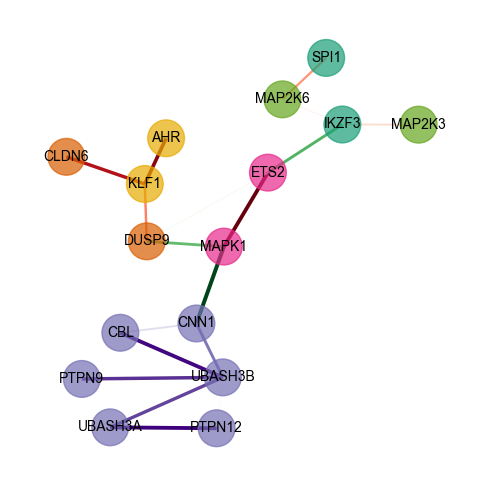

In [169]:
with plt.rc_context({'figure.figsize': (6,6),'font.sans-serif':['Arial']}):
    layout = nx.kamada_kawai_layout(G)
    #layout = nx.circular_layout(G)
    #layout=nx.shell_layout(G)
    #layout=nx.spiral_layout(G)
    
    layout['DUSP9']=layout['DUSP9']+np.array([-0.2,-0.26])
    layout['CLDN6']=layout['CLDN6']+np.array([0.14,0])
    layout['AHR']=np.array([-0.18, 0.55])
    layout['PTPN12']=layout['PTPN12']+np.array([0,-0.15])
    layout['PTPN9']=layout['PTPN9']+np.array([-0.65,0.20])
    layout['MAP2K6']=layout['MAP2K6']+np.array([-0.1,0])
    
    selected_edges=[(u,v) for u,v,e in G.edges.data() if e['GI_type']=='BF']
    weights=np.array([G.get_edge_data(u,v)['weight'] for u,v in selected_edges])
    nx.draw_networkx_edges(G, layout,edgelist=selected_edges,edge_color=weights*2,width=weights*3,edge_cmap=plt.cm.Reds,node_size=900)

    selected_edges=[(u,v) for u,v,e in G.edges.data() if e['GI_type']=='SY']
    weights=np.array([G.get_edge_data(u,v)['weight'] for u,v in selected_edges])
    nx.draw_networkx_edges(G, layout,edgelist=selected_edges,edge_color=weights*2,width=weights*3,edge_cmap=plt.cm.Purples,node_size=900)

    selected_edges=[(u,v) for u,v,e in G.edges.data() if e['GI_type']=='DM']
    weights=np.array([G.get_edge_data(u,v)['weight'] for u,v in selected_edges])
    nx.draw_networkx_edges(G, layout,edgelist=selected_edges,edge_color=weights*2,width=weights*3,edge_cmap=plt.cm.Greens,node_size=900)

    nx.draw_networkx_nodes(G,layout,node_color=[cmap(G.nodes[n]['cluster']) for n in G.nodes()],node_size=700,margins=0.1,alpha=0.7)
    nx.draw_networkx_labels(G,layout,font_size=10,font_color='k')
    plt.box(False)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','Factor7_GI_res.svg'), dpi=1000, bbox_inches="tight",transparent=True)
    plt.show()

<a id="18"></a> 
# 6 Combining p-values: GI at the whole transcriptome level

In addition to inferring GIs at the factor level, scCAPE also provided inference results on the overall transcriptome by combining p-values.

In [171]:
res=sccape.cal_ACAT_pvals(dataset_name=dataset_name,target='MAP2K3+IKZF3',factor_nums=12,alpha=0.05,weights=None,return_res=True,save=False)

Finish ACAT calculation in target=MAP2K3+IKZF3


In [172]:
res.head(4)

pval_SY   pval_BF   pval_DM      pval_epia  pval_epib  sig_SY  sig_BF  \
0  0.999891  0.999891  0.999955   2.384759e-13   0.999244     0.0     0.0   
1  0.999914  0.001812  0.999946  2.051910e-162   0.999599     0.0     1.0   
2  0.999922  0.999922  0.999933   4.133170e-35   0.999223     0.0     0.0   
3  0.999864  0.999864  0.999952   5.559220e-06   0.000974     0.0     0.0   

   sig_DM  sig_epia  sig_epib  sig_RD  
0     0.0       0.0       1.0     0.0  
1     0.0       0.0       1.0     0.0  
2     0.0       0.0       1.0     0.0  
3     0.0       0.0       0.0     0.0

In [ ]:
# pval_SY, pval_BF, pval_DM, pval_epia, pval_epib: combined pval (across all factors) of GI tests (Synergistic, buffering, dominant, epistasis a, epistasis b)
# sig_SY, sig_BF, sig_DM, sig_epia, sig_epib: sig of GI tests [significant (1) or not (0)]
# sig_RD: indicator of redundant (tau_ab=tau_a=tau_b)

Calculate all gene pairs using for-loops:

In [173]:
target_list=[]
for i in list(adata.obs.condition.cat.categories):
    if len(i.split('+'))==2:
        target_list.append(i)

In [174]:
single_target_list=[]
for i in list(adata.obs.condition.cat.categories):
    if len(i.split('+'))==1 and i!='control':
        single_target_list.append(i)

In [175]:
# percentage of significant cells
SY_ACAT_res=pd.DataFrame(np.nan,index=single_target_list,columns=single_target_list)
BF_ACAT_res=pd.DataFrame(np.nan,index=single_target_list,columns=single_target_list)
DM_ACAT_res=pd.DataFrame(np.nan,index=single_target_list,columns=single_target_list)
epiA_ACAT_res=pd.DataFrame(np.nan,index=single_target_list,columns=single_target_list)
epiB_ACAT_res=pd.DataFrame(np.nan,index=single_target_list,columns=single_target_list) 

In [176]:
for target in target_list:
    res=sccape.cal_ACAT_pvals(dataset_name=dataset_name,target=target,factor_nums=12,alpha=0.05,weights=None,return_res=True,save=True)
    target1=target.split('+')[0]
    target2=target.split('+')[1]
    SY_ACAT_res.loc[target1,target2]=res.mean(axis=0)['sig_SY']
    BF_ACAT_res.loc[target1,target2]=res.mean(axis=0)['sig_BF']
    DM_ACAT_res.loc[target1,target2]=res.mean(axis=0)['sig_DM']
    epiA_ACAT_res.loc[target1,target2]=res.mean(axis=0)['sig_epia']
    epiB_ACAT_res.loc[target1,target2]=res.mean(axis=0)['sig_epib']

In [177]:
np.save(os.path.join(dataset_name,'CausalForests','BF_ACAT_all_res.npy'),BF_ACAT_res)
np.save(os.path.join(dataset_name,'CausalForests','SY_ACAT_all_res.npy'),SY_ACAT_res)
np.save(os.path.join(dataset_name,'CausalForests','DM_ACAT_all_res.npy'),DM_ACAT_res)
np.save(os.path.join(dataset_name,'CausalForests','epiA_ACAT_all_res.npy'),epiA_ACAT_res)
np.save(os.path.join(dataset_name,'CausalForests','epiB_ACAT_all_res.npy'),epiB_ACAT_res)

<a id="19"></a> 
## 6.1 Directed graph visualization

In [178]:
import networkx as nx

In [179]:
single_target_list=[]
for i in list(adata.obs.condition.cat.categories):
    if len(i.split('+'))==1 and i!='control':
        single_target_list.append(i)

In [180]:
epiA_ACAT_all_res=pd.DataFrame(np.load(os.path.join(dataset_name,'CausalForests','epiA_ACAT_all_res.npy')),
                               index=single_target_list,columns=single_target_list)
epiB_ACAT_all_res=pd.DataFrame(np.load(os.path.join(dataset_name,'CausalForests','epiB_ACAT_all_res.npy')),
                               index=single_target_list,columns=single_target_list)

In [181]:
with open(os.path.join(dataset_name,'pert_clust_dict.pkl'), 'rb') as f:
    pert_clust_dict= pickle.load(f)# target clusters obtained from the last section in this notebook.

In [182]:
cutoff=0.2

query_list=['IKZF3','HOXC13','DUSP9','PTPN12','IGDCC3','PRTG','SGK1','TBX2','TBX3',
            'MAPK1','ETS2','BAK1','FOSB','MAP2K3','MAP2K6','ZC3HAV1','KLF1','AHR','TGFBR2']
query_cluster=[pert_clust_dict[pert] for pert in query_list]
cmap=plt.colormaps['Dark2']

In [183]:
query_dict=dict(zip(query_list,query_cluster))

In [184]:
edges_list=[]
for i in range(len(query_list)):
    for j in np.arange(i+1,len(query_list)):
        if (query_list[i]+'+'+query_list[j]) in target_list:
            edges_list.append([query_list[i],query_list[j],
                               epiA_ACAT_all_res.loc[query_list[i],query_list[j]],
                               epiB_ACAT_all_res.loc[query_list[i],query_list[j]]])
        if (query_list[j]+'+'+query_list[i]) in target_list:
            edges_list.append([query_list[j],query_list[i],
                               epiA_ACAT_all_res.loc[query_list[j],query_list[i]],
                               epiB_ACAT_all_res.loc[query_list[j],query_list[i]]])

In [185]:
edges_df=pd.DataFrame(edges_list,columns=['source','target','epiA','epiB'])
check_GI_type=['epiA','epiB']
edges_df['GI_type']=(edges_df.loc[:,check_GI_type]).idxmax(axis=1)
edges_df['weight']=(edges_df.loc[:,check_GI_type]).max(axis=1)
swap_idx=(edges_df['GI_type'] == 'epiB')
edges_df.loc[swap_idx,['source','target']] = edges_df.loc[swap_idx,['target','source']].values
edges_df=edges_df.drop(['epiA','epiB','GI_type'],axis=1)
edges_df['cluster']=edges_df.source.map(query_dict)
edges_df=edges_df[edges_df.weight>cutoff]

In [186]:
G = nx.from_pandas_edgelist(edges_df,source='source',target='target',edge_attr=True,create_using=nx.DiGraph())

In [187]:
G.add_nodes_from([(query_list[i],{'cluster':query_cluster[i]}) for i in range(len(query_list))])

In [188]:
from matplotlib.patches import ArrowStyle

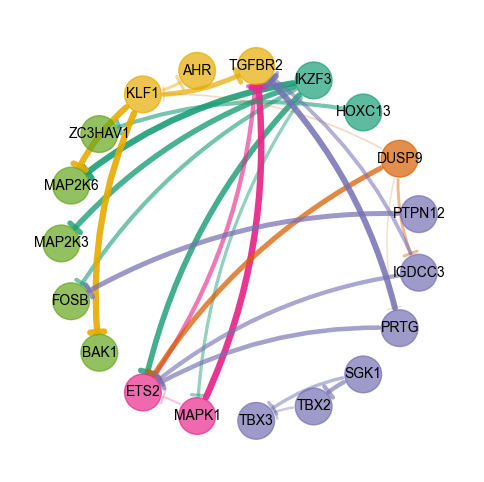

In [189]:
with plt.rc_context({'figure.figsize': (6,6),'font.sans-serif':['Arial']}):
    #layout = nx.kamada_kawai_layout(G)
    #layout = nx.circular_layout(G)
    layout=nx.shell_layout(G)
    layout_maps=['TGFBR2','PTPN12','KLF1','PRTG','IGDCC3','DUSP9',
                 'ZC3HAV1','HOXC13','MAP2K6','MAP2K3','FOSB','ETS2',
                 'MAPK1','IKZF3','AHR','BAK1','TBX3','TBX2','SGK1']
    locs=[layout[pert] for pert in layout_maps]
    layout_new=dict(zip(query_list,locs))
    for edge in G.edges(data=True):
        nx.draw_networkx_edges(G, layout_new, edgelist=[edge], edge_color=cmap(edge[2]['cluster']), 
                               width=edge[2]['weight']*5,alpha=edge[2]['weight'],
                               connectionstyle="arc3,rad=0.15",arrowstyle=ArrowStyle.BracketB(widthB=0.5, lengthB=0),node_size=900)
    
    nx.draw_networkx_nodes(G,layout_new,node_color=[cmap(G.nodes[n]['cluster']) for n in G.nodes()],node_size=700,margins=0.1,alpha=0.7)
    nx.draw_networkx_labels(G,layout_new,font_size=10,font_color='k')
    plt.box(False)
    #plt.savefig(os.path.join('all_figs','Norman2019_highMOI_figs','ACAT_epi_res.svg'), dpi=1000, bbox_inches="tight",transparent=True)
    plt.show()

In [202]:
# ['IKZF3','HOXC13','DUSP9','PTPN12','IGDCC3','PRTG','SGK1','TBX2','TBX3','MAPK1','ETS2','BAK1','FOSB','MAP2K3','MAP2K6','ZC3HAV1','KLF1','AHR','TGFBR2']
# layout_maps=['TGFBR2','PTPN12','KLF1','PRTG','IGDCC3','DUSP9','ZC3HAV1','HOXC13','MAP2K6','MAP2K3','FOSB','ETS2','MAPK1','IKZF3','AHR','BAK1','TBX3','TBX2','SGK1']
# locs=[layout[pert] for pert in layout_maps]
# layout_new=dict(zip(query_list,locs))

<a id="20"></a> 
## 6.2 Example: SGK1/TBX2/TBX3

### SGK1/TBX2

In [190]:
target='SGK1+TBX2'
target1=target.split('+')[0]
target2=target.split('+')[1]
factor=6
subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
subset=subset[subset.obs.condition.isin(['control',target1,target2,target])]
ctrl_vec=np.array((subset[subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((subset[subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((subset[subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((subset[subset.obs.condition==target].X).mean(axis=0))[0,:]
drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec)],
                    index=[target1,target2,target,'Int'],columns=subset.var_names)
regr_m = LinearRegression(fit_intercept=False)
x_m=np.column_stack((a_vec-ctrl_vec,b_vec-ctrl_vec))
y_m=ab_vec-ctrl_vec
regr_m.fit(np.asarray(x_m), np.asarray(y_m))
#regr_m.coef_
[regr_m.coef_[0],regr_m.coef_[1],np.sqrt(regr_m.coef_[0]**2+regr_m.coef_[1]**2),np.log10(abs(regr_m.coef_[0]/regr_m.coef_[1]))]

[0.9280993, 0.87657124, 1.2766148201157608, 0.024807226]

In [175]:
all_res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format(target,factor)))
a_mean=all_res_ctrl.mean(axis=0)[0]
b_mean=all_res_ctrl.mean(axis=0)[1]
int_mean=all_res_ctrl.mean(axis=0)[2]
[a_mean,b_mean,int_mean]

[1.5020103285779307, 0.6363044216053063, -0.028566058006769725]

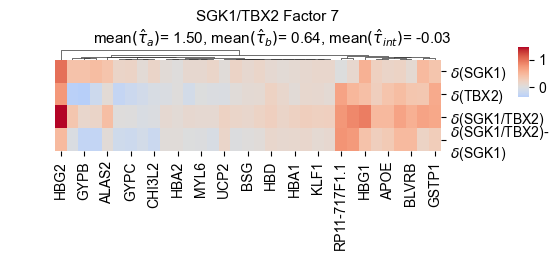

In [176]:
kws = dict(cbar_kws=dict(ticks=[ 0, 1], orientation='vertical'),figsize=(5.5, 2.5))
with plt.rc_context({'figure.figsize': (4, 2),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    g=sns.clustermap(drawdf,row_cluster=False,dendrogram_ratio=0.1,cmap=sns.color_palette("coolwarm", as_cmap=True),center=0,**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.95, 0.75, 0.02, 0.2])
    #g.ax_cbar.set_title('Expression',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    #g.ax_heatmap.set_xlabel('Genes in Factor '+str(factor+1))
    g.ax_heatmap.set_xlabel("")
    #g.ax_heatmap.set_xticks(labelsize=8)
    g.ax_heatmap.set_yticks(np.arange(4)+0.5,[r'$\delta$'+'('+target1+')',
                                              r'$\delta$'+'('+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')-\n'+r'$\delta$'+'('+target1+')'])
    g.fig.suptitle(target1+'/'+target2+' '+'Factor '+str(factor+1)+' '+
                   '\n mean$(\\hat{\\tau}_a)$= 1.50, '+'mean$(\hat{\\tau}_b)$= 0.64, '+'mean$(\hat{\\tau}_{int})$= -0.03',y=1.1,x=0.5,fontsize=11) 
    #plt.savefig(os.path.join('all_figs','supp_figs','SGK1+TBX2_factor7.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

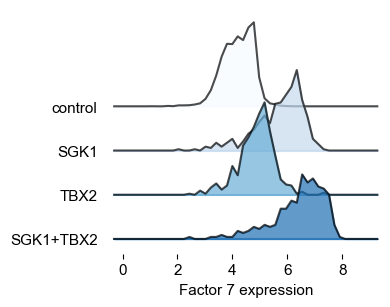

In [177]:
subset=treated[treated.obs.condition.isin(['control',target1,target2,target])]
subset=subset[:,str(factor)]
drawdf=pd.DataFrame([np.array(subset.X)[:,0],subset.obs.condition],index=['vals','condition'])
drawdf=drawdf.T
cat_type = pd.CategoricalDtype(categories=['control', target1, target2,target])
drawdf.condition=drawdf.condition.astype(cat_type)
with plt.rc_context({'figure.figsize': (4, 3),'font.sans-serif':['Arial']}):
    fig,axs=joyplot(
        data=drawdf,
        xlabelsize=11,
        ylabelsize=11,
        by='condition',
        column=['vals'],
        legend=False,
        alpha=0.7,
        #x_range=[7.5,10.5],
        #range_style='own',
        kind='normalized_counts',
        bins=50,
        #hist=True, bins=80,
        colormap=plt.get_cmap('Blues'),
        xlabels=True)
    axs[-1].set_xlabel('Factor {} expression'.format(factor+1),fontsize=11)
    #plt.savefig(os.path.join('all_figs','supp_figs','SGK1+TBX2_factor7_2.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

### SGK1/TBX3

In [178]:
target='SGK1+TBX3'
target1=target.split('+')[0]
target2=target.split('+')[1]
factor=6
subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
subset=subset[subset.obs.condition.isin(['control',target1,target2,target])]
ctrl_vec=np.array((subset[subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((subset[subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((subset[subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((subset[subset.obs.condition==target].X).mean(axis=0))[0,:]
drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(a_vec-ctrl_vec)],
                    index=[target1,target2,target,'Int'],columns=subset.var_names)
regr_m = LinearRegression(fit_intercept=False)
x_m=np.column_stack((a_vec-ctrl_vec,b_vec-ctrl_vec))
y_m=ab_vec-ctrl_vec
regr_m.fit(np.asarray(x_m), np.asarray(y_m))
#regr_m.coef_
[regr_m.coef_[0],regr_m.coef_[1],np.sqrt(regr_m.coef_[0]**2+regr_m.coef_[1]**2),np.log10(abs(regr_m.coef_[0]/regr_m.coef_[1]))]

[0.83322316, 0.60125047, 1.0275032693174566, 0.1417059]

In [179]:
all_res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format(target,factor)))
a_mean=all_res_ctrl.mean(axis=0)[0]
b_mean=all_res_ctrl.mean(axis=0)[1]
int_mean=all_res_ctrl.mean(axis=0)[2]
[a_mean,b_mean,int_mean]

[1.4986719812743978, -0.20779668100054002, -0.2052978938436555]

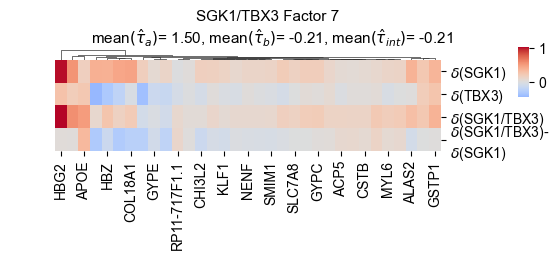

In [180]:
kws = dict(cbar_kws=dict(ticks=[ 0, 1], orientation='vertical'),figsize=(5.5, 2.5))
with plt.rc_context({'figure.figsize': (4, 2),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    g=sns.clustermap(drawdf,row_cluster=False,dendrogram_ratio=0.1,cmap=sns.color_palette("coolwarm", as_cmap=True),center=0,**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.95, 0.75, 0.02, 0.2])
    #g.ax_cbar.set_title('Expression',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    #g.ax_heatmap.set_xlabel('Genes in Factor '+str(factor+1))
    g.ax_heatmap.set_xlabel("")
    #g.ax_heatmap.set_xticks(labelsize=8)
    g.ax_heatmap.set_yticks(np.arange(4)+0.5,[r'$\delta$'+'('+target1+')',
                                              r'$\delta$'+'('+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')-\n'+r'$\delta$'+'('+target1+')'])
    g.fig.suptitle(target1+'/'+target2+' '+'Factor '+str(factor+1)+' '+
                   '\n mean$(\\hat{\\tau}_a)$= 1.50, '+'mean$(\hat{\\tau}_b)$= -0.21, '+'mean$(\hat{\\tau}_{int})$= -0.21',y=1.1,x=0.5,fontsize=11) 
    #plt.savefig(os.path.join('all_figs','supp_figs','SGK1+TBX3_factor7.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

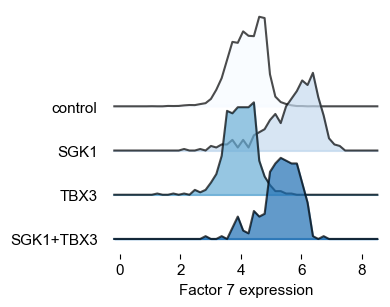

In [181]:
subset=treated[treated.obs.condition.isin(['control',target1,target2,target])]
subset=subset[:,str(factor)]
drawdf=pd.DataFrame([np.array(subset.X)[:,0],subset.obs.condition],index=['vals','condition'])
drawdf=drawdf.T
cat_type = pd.CategoricalDtype(categories=['control', target1, target2,target])
drawdf.condition=drawdf.condition.astype(cat_type)
with plt.rc_context({'figure.figsize': (4, 3),'font.sans-serif':['Arial']}):
    fig,axs=joyplot(
        data=drawdf,
        xlabelsize=11,
        ylabelsize=11,
        by='condition',
        column=['vals'],
        legend=False,
        alpha=0.7,
        #x_range=[7.5,10.5],
        #range_style='own',
        kind='normalized_counts',
        bins=50,
        #hist=True, bins=80,
        colormap=plt.get_cmap('Blues'),
        xlabels=True)
    axs[-1].set_xlabel('Factor {} expression'.format(factor+1),fontsize=11)
    #plt.savefig(os.path.join('all_figs','supp_figs','SGK1+TBX3_factor7_2.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

### TBX3/TBX2

In [182]:
target='TBX3+TBX2'
target1=target.split('+')[0]
target2=target.split('+')[1]
factor=6
subset=adata[:,adata.var_names[genes_do_go[str(factor)]]]
subset=subset[subset.obs.condition.isin(['control',target1,target2,target])]
ctrl_vec=np.array((subset[subset.obs.condition=='control'].X).mean(axis=0))[0,:]
a_vec=np.array((subset[subset.obs.condition==target1].X).mean(axis=0))[0,:]
b_vec=np.array((subset[subset.obs.condition==target2].X).mean(axis=0))[0,:]
ab_vec=np.array((subset[subset.obs.condition==target].X).mean(axis=0))[0,:]
drawdf=pd.DataFrame([a_vec-ctrl_vec,b_vec-ctrl_vec,ab_vec-ctrl_vec,ab_vec-ctrl_vec-(b_vec-ctrl_vec)],
                    index=[target1,target2,target,'Int'],columns=subset.var_names)
regr_m = LinearRegression(fit_intercept=False)
x_m=np.column_stack((a_vec-ctrl_vec,b_vec-ctrl_vec))
y_m=ab_vec-ctrl_vec
regr_m.fit(np.asarray(x_m), np.asarray(y_m))
#regr_m.coef_
[regr_m.coef_[0],regr_m.coef_[1],np.sqrt(regr_m.coef_[0]**2+regr_m.coef_[1]**2),np.log10(abs(regr_m.coef_[0]/regr_m.coef_[1]))]

[0.47570792, 0.8312377, 0.9577338324977166, -0.24238484]

In [183]:
all_res_ctrl=np.load(os.path.join(dataset_name,'CausalForests','GI_res_target={}_factor={}.npy'.format(target,factor)))
a_mean=all_res_ctrl.mean(axis=0)[0]
b_mean=all_res_ctrl.mean(axis=0)[1]
int_mean=all_res_ctrl.mean(axis=0)[2]
[a_mean,b_mean,int_mean]

[-0.2047793986836262, 0.6355801793993716, 0.048497881732000765]

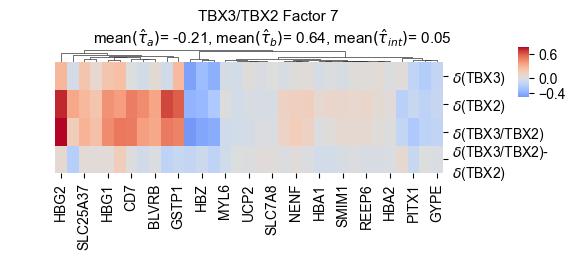

In [184]:
kws = dict(cbar_kws=dict(ticks=[ -0.4,0, 0.6], orientation='vertical'),figsize=(5.5, 2.5))
with plt.rc_context({'figure.figsize': (4, 2),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    g=sns.clustermap(drawdf,row_cluster=False,dendrogram_ratio=0.1,cmap=sns.color_palette("coolwarm", as_cmap=True),center=0,**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.95, 0.75, 0.02, 0.2])
    #g.ax_cbar.set_title('Expression',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    #g.ax_heatmap.set_xlabel('Genes in Factor '+str(factor+1))
    g.ax_heatmap.set_xlabel("")
    #g.ax_heatmap.set_xticks(labelsize=8)
    g.ax_heatmap.set_yticks(np.arange(4)+0.5,[r'$\delta$'+'('+target1+')',
                                              r'$\delta$'+'('+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')',
                                              r'$\delta$'+'('+target1+'/'+target2+')-\n'+r'$\delta$'+'('+target2+')'])
    g.fig.suptitle(target1+'/'+target2+' '+'Factor '+str(factor+1)+' '+
                   '\n mean$(\\hat{\\tau}_a)$= -0.21, '+'mean$(\hat{\\tau}_b)$= 0.64, '+'mean$(\hat{\\tau}_{int})$= 0.05',y=1.1,x=0.5,fontsize=11) 
    #plt.savefig(os.path.join('all_figs','supp_figs','TBX3+TBX2_factor7.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

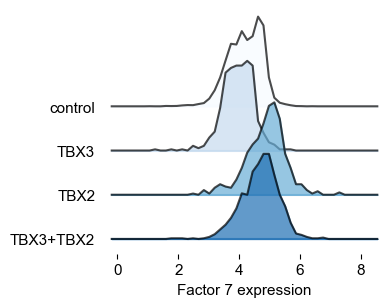

In [185]:
subset=treated[treated.obs.condition.isin(['control',target1,target2,target])]
subset=subset[:,str(factor)]
drawdf=pd.DataFrame([np.array(subset.X)[:,0],subset.obs.condition],index=['vals','condition'])
drawdf=drawdf.T
cat_type = pd.CategoricalDtype(categories=['control', target1, target2,target])
drawdf.condition=drawdf.condition.astype(cat_type)
with plt.rc_context({'figure.figsize': (4, 3),'font.sans-serif':['Arial']}):
    fig,axs=joyplot(
        data=drawdf,
        xlabelsize=11,
        ylabelsize=11,
        by='condition',
        column=['vals'],
        legend=False,
        alpha=0.7,
        #x_range=[7.5,10.5],
        #range_style='own',
        kind='normalized_counts',
        bins=50,
        #hist=True, bins=80,
        colormap=plt.get_cmap('Blues'),
        xlabels=True)
    axs[-1].set_xlabel('Factor {} expression'.format(factor+1),fontsize=11)
    #plt.savefig(os.path.join('all_figs','supp_figs','TBX3+TBX2_factor7_2.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="21"></a> 
# 7 Overall targets distance

In [191]:
num_genes_go=[len(genes_do_go[key]) for key in genes_do_go.keys()]
factor_weights=np.array(num_genes_go)/sum(num_genes_go)

CAUTION: This will take several hours on a laptop.

In [192]:
sccape.CF_all_target_all_factor(dataset_name, basal, treated, adata, pert_key='condition', n_estimators=500,
                             min_samples_leaf=5, one_side=False, verbose=False, random_state=0, alpha=0.05) # Estimate CATE for all targets

In [193]:
with open(os.path.join(dataset_name,'CausalForests','tau_factor_mean_all_dict.pkl'), 'rb') as fp:
    tau_factor_mean_all_dict = pickle.load(fp)
with open(os.path.join(dataset_name,'CausalForests','tau_q_val_factor_all_dict.pkl'), 'rb') as fp:
    tau_q_val_factor_all_dict = pickle.load(fp)
with open(os.path.join(dataset_name,'CausalForests','sig_factor_all_dict.pkl'), 'rb') as fp:
    sig_factor_all_dict = pickle.load(fp)

In [195]:
clust_mean_df, clust_sig_df=sccape.cal_clust_mean(adata, tau_factor_mean_all_dict, sig_factor_all_dict, 
                                                   aggregate_key='cell_type', pert_key='condition')

In [196]:
distance_df=sccape.cal_overall_similarity(adata, tau_factor_mean_all_dict, factor_weights, cluster_name='All', aggregate_key='cell_type',
                           pert_key='condition')

In [197]:
distance_df.to_csv(os.path.join(dataset_name,'overall_distance_df.csv'))

In [199]:
distance_df=pd.read_csv(os.path.join(dataset_name,'overall_distance_df.csv'),index_col=0)

In [200]:
from PyComplexHeatmap import *

Starting plotting..
Starting calculating row orders..
Reordering rows..


C:\ProgramData\anaconda\lib\site-packages\PyComplexHeatmap\clustermap.py:832: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


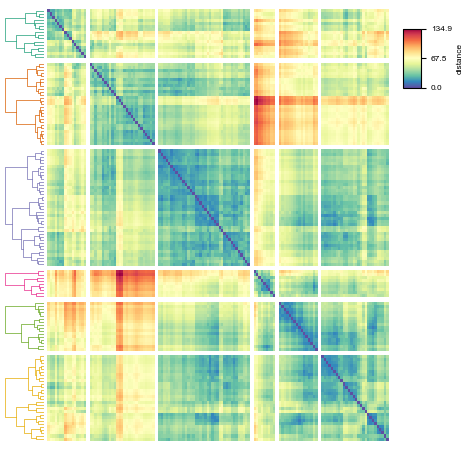

In [201]:
with plt.rc_context({'font.sans-serif': ['Arial'],'font.size':6}):
    plt.figure(figsize=(5, 5))
    cm = ClusterMapPlotter(data=distance_df,  col_split=6, row_split=6, col_split_gap=1,
                           row_cluster_metric='euclidean',
                           col_cluster_metric='euclidean',
                           row_cluster_method='ward',
                           col_cluster_method='ward',
                           row_split_gap=1,label='distance',
                           row_dendrogram=True,col_dendrogram=False,show_rownames=False,show_colnames=False,
                           tree_kws={'row_cmap': 'Dark2'},cmap='Spectral_r',
                           legend_gap=5,legend_hpad=2,legend_vpad=5)
    plt.show()

In [202]:
gene_modules_full=cm.row_order
pert_list=[]
pert_clust_list=[]
for i in range(len(gene_modules_full)):
    for pert in gene_modules_full[i]:
        pert_list.append(pert)
        pert_clust_list.append(i)
pert_clust_dict=dict(zip(pert_list,pert_clust_list))

In [203]:
with open(os.path.join(dataset_name,'pert_clust_dict.pkl'), 'wb') as f:
    pickle.dump(pert_clust_dict, f)

In [204]:
with open(os.path.join(dataset_name,'pert_clust_dict.pkl'), 'rb') as f:
    loaded_dict = pickle.load(f)

In [205]:
selected_rows = ['SPI1','IKZF3',
               'DUSP9','CLDN6',
               'TBX2','TBX3','CNN1','CBL','PTPN12','PTPN9','UBASH3A','UBASH3B',
              'MAPK1', 'ETS2', 'COL2A1',
              'MAP2K3','MAP2K6','SLC38A2','BAK1',
              'HOXB9','KLF1','AHR','FEV','FOXF1','FOXL2']
label_rows = distance_df.apply(lambda x:x.name if x.name in selected_rows else None,axis=0)

In [206]:
cmap=plt.cm.get_cmap('Dark2')
colors_dict={}
for g in selected_rows:
    colors_dict[g]=cmap((pert_clust_dict[g]))

C:\Users\17794\AppData\Local\Temp\ipykernel_24372\2405176171.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Dark2')


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


C:\ProgramData\anaconda\lib\site-packages\PyComplexHeatmap\clustermap.py:832: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Plotting legends..
Estimated legend width: 7.5 mm


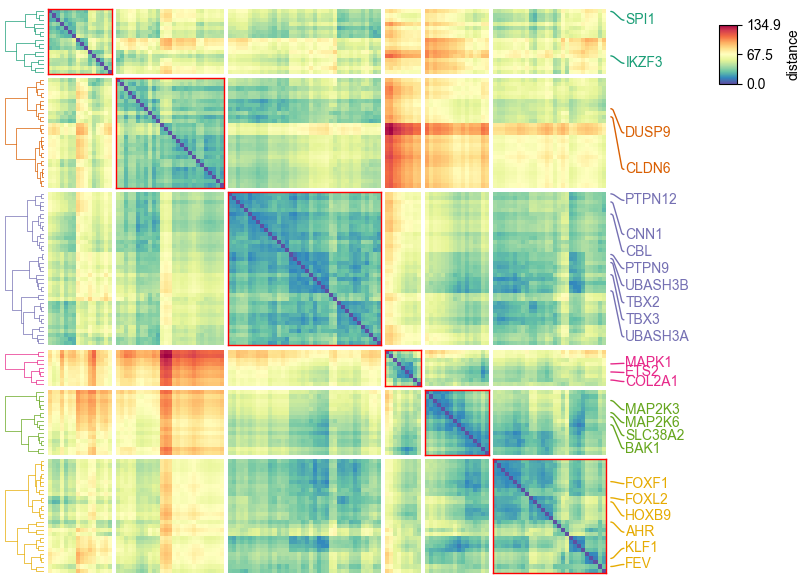

In [207]:
with plt.rc_context({'font.sans-serif': ['Arial']}):
    plt.figure(figsize=(8, 6.5))
    row_ha = HeatmapAnnotation(
                            selected=anno_label(label_rows,merge=True,extend=True,colors=colors_dict,relpos=(0,0.5)),
                            axis=0,verbose=0,orientation='right'
                            )
    
    cm = ClusterMapPlotter(data=distance_df,right_annotation=row_ha,#top_annotation=col_ha,right_annotation=row_ha,
                           col_split=6, row_split=6, col_split_gap=1,
                           row_cluster_metric='euclidean',
                           col_cluster_metric='euclidean',
                           row_cluster_method='ward',
                           col_cluster_method='ward',
                           row_split_gap=1,label='distance',
                           row_dendrogram=True,col_dendrogram=False,show_rownames=False,show_colnames=False,
                           tree_kws={'row_cmap': 'Dark2'},cmap='Spectral_r',
                           legend_gap=5,legend_hpad=2,legend_vpad=5,
                           xticklabels_kws={'labelsize':8})

    for i in range(cm.heatmap_axes.shape[0]):
        for j in range(cm.heatmap_axes.shape[1]):
            if i != j:
                continue
            ax = cm.heatmap_axes[i][j]
            for side in ["top", "right", "left", "bottom"]:
                ax.spines[side].set_visible(True)
                ax.spines[side].set_color('red')
                ax.spines[side].set_linewidth(1)
    #plt.savefig(os.path.join('all_figs','Similarity_ranking_figs','Norman2019_highMOI_overall_dis2.svg'), dpi=1000, bbox_inches="tight")
    plt.show()